# 📜 Libraries and Functions


In [1]:
# Data wrangling
import pandas as pd
import numpy as np
import random

# Data visualisation
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import f

# Machine learning
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.inspection import PartialDependenceDisplay

# My functions
import sys

sys.path.insert(0, "../../src")
from run_mp import *
from utilities import *
from random_forest_utils import *

# Other
from os import error
import datetime
from io import StringIO
import re
import warnings
import chime
from pyprojroot import here

chime.theme("mario")

# Magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

# 👤 User Input


In [2]:
# Options:

# - imputation_method = knn mean median minus_9999
# - weight_method = none squared cubic quadratic inverse inverse_squared

In [3]:
# NFI file name
nfi_file_name = "20231201-103649_nfi_dataset_for_analysis copy.csv"

# Folder prefix
folder_suffix = ""  # None for no prefix

user_input = {
    # Add Datasets
    "add_nfi_original": True,
    "add_nfi_derivatives": True,
    "add_gee_data": True,
    "add_rmqs_data": False,
    "add_edo_data": False,
    "add_apt_data": False,
    "add_dem_data": True,
    # Subsetting NFIx
    "rerun_calculation_growth_mortality": True,  # ONLY HAVE TO RERUN THIS IF SUBSETTING SPECIES!
    "subset_nfi": False,
    "subset_min_trees_per_plot": 10,  # Set to None or 0 for no subsetting
    "subset_species": "Quercus",  # Set to "all" for no subsetting
    # Feature Selection
    "na_drop_threshold": 0.1,
    # Entry Selection
    "add_target_0s": False,  # False = Remove all 0 values from target
    "add_target_0s_percentage": 0.01,
    "add_target_0s_strata": "ser",  # Set to "none" if no strata should be used
    # Entry imputation
    "imputation_method": "mean",
    # 🎯 RF Definition
    "target": "mort_ba_prc_yr_v1",
    "test_train_strata": [
        "gre",
        "campagne_1",
        "top1_species_nfi",
    ],
    # Regression
    "reduce_to_percentile": False,  # If True, reduce dataset to percentile
    "percentile_n_group": 5,  # Data should be split into how many groups
    "percentile_group": 4,  # Which group should be used (starting indexing at 0)!
    # Classification
    "make_classification": False,
    "classification_groups": 5,
    # ⚙️ RF Tuning
    "weight_method": "none",
    "cv_folds": 5,
    "test_split": 0.3,
    "do_random_search": False,
    "do_prescribed_search": False,
    "do_ref": False,
    "seed_nr": 42,
}

# Data Wrangling
run_reports_major = True
run_reports_minor = False

# --------------------------------------------------
# GREY = KEEP
# GREEN = REMOVED
# If not specified otherwise in google sheet or in routine

user_input_variable_removal = [
    # ! Variables with temporal information
    # "campagne_1",
    "campagne_2",
    "visite_1",
    "visite_2",
    "census_interval",
    # ! Variables with spatial information
    "ser",
    "gre",
    "dep",
    "lat",
    "lon",
    "lat_fr",
    "lon_fr",
    # ! Variables from NFI derivatives that hold ba information
    "site_ba_prc_cut_at_v2",
    "site_ba_prc_dead_at_v1",
    "site_ba_prc_dead_at_v2",
    "site_ba_prc_rec_at_v2",
    "site_total_ba_at_v1",
    "site_total_ba_at_v2",
    "ntrees_1",
    "ntrees_2",
    # ! Variables from calculation_growth_mortality:
    # * General variables / stand descriptions
    "idp",
    "n_plots",
    "n_ini",
    "n_sur",
    "n_fin",
    "n_rec",
    "n_die",
    "ba_at_v1_of_alive_trees",
    "ba_at_v2_of_alive_trees",
    "ba_at_v1_of_survivors",
    "ba_at_v2_of_survivors",
    "ba_at_v1_of_dead",
    "ba_at_v2_of_dead",
    "ba_at_v2_of_recruits",
    # * Growth and Mortality variables
    "mort_stems_prc_yr_esq",  # <--- Target variable ESQ
    "mort_stems_prc_yr_hoshino",
    "rec_stems_prc_yr_hoshino",
    "mort_ba_prc_yr_hoshino",
    "tot_growth_ba_prc_yr_hoshino",
    "sur_growth_ba_prc_yr_hoshino",
    "tot_growth_ba_yr",
    "sur_growth_ba_yr",
    "mort_ba_yr_v1",  # <--- Target variable ABS
    "mort_ba_yr_v2",
    "tot_growth_ba_prc_yr",
    "sur_growth_ba_prc_yr",
    "mort_ba_prc_yr_v1",  # <--- Target variable PRC
    "mort_ba_prc_yr_v2",
]

user_input["features_to_remove"] = user_input_variable_removal

# --------------------------------------------------
# TODO: Needs to be cleaned up
add_gee_data = user_input["add_gee_data"]
target = user_input["target"]
na_drop_threshold = user_input["na_drop_threshold"]
seed_nr = user_input["seed_nr"]
test_split = user_input["test_split"]
test_train_strata = user_input["test_train_strata"]

# Set output folder


In [4]:
# Get current directory
current_dir = create_new_run_folder(folder_suffix=folder_suffix)

# Write to file
file_path = f"{current_dir}/user_input.txt"
with open(file_path, "w") as file:
    for key, value in user_input.items():
        if isinstance(value, list):
            file.write(f"{key}:")
            for v in value:
                file.write(f"\n - {v}")
            file.write("\n\n")
        else:
            file.write(f"{key}:\n - {value}\n\n")


# Create txt file with name
def write_txt(text):
    with open(text, "w") as file:
        pass


# Add a few quick_see_files
write_txt(f"{current_dir}/_{user_input['target']}.txt")
write_txt(f"{current_dir}/_classification_{user_input['make_classification']}.txt")
write_txt(
    f"{current_dir}/_percentile_{user_input['reduce_to_percentile']}_group_{user_input['percentile_group']+1}of{user_input['percentile_n_group']}.txt"
)

# 💽 Load Data


### Subset Stand Properties


In [19]:
do_subset_mortality_group = True
subset_variable = "genus_lat"
subset_level = "Quercus"
# # Additional user_input filters
# shape_org = nfi_subsetted_trees.shape
# nfi_user_subset = nfi_subsetted_trees.copy()

# # Species Subsetting
# if user_input["subset_species"] != "all":
#     nfi_user_subset = nfi_user_subset.query(
#         f"genus_lat == '{user_input['subset_species']}'"
#     )
#     print(
#         f"Filter subset_species \t| Subsetting to species {user_input['subset_species']}:\t\t {nfi_user_subset.shape}"
#     )

# else:
#     # No subsetting
#     print("No subsetting done.")

# write_txt(f"{current_dir}/_species-genus_lat-subset_{user_input['subset_species']}.txt")

# print(
#     f"\nSubsetting based on user input changed df from \n {shape_org} to \n {nfi_user_subset.shape}"
# )

In [22]:
df_for_subset_mortality = nfi_filter_trees[
    [
        "idp",
        "group_id",
        "ba_1",
        "ba_2",
        "tree_state_change",
        "tree_state_1",
        "tree_state_2",
        "genus_lat",
        "species_lat",
        "espar_red",
    ]
]
# df_for_subset_mortality = df_for_subset_mortality.query("idp == 501554")

In [23]:
if do_subset_mortality_group:
    # Subset to mortality group
    ss_grouped = df_for_subset_mortality[
        nfi_filter_trees["genus_lat"] == subset_level
    ].groupby("group_id", as_index=False)
    # Get list of dataframes
    ss_df_list = [group for name, group in ss_grouped]
    ss_df_list = ss_df_list  # For debug, reduce number to 100 sites only
    # Do multiprocess
    ss_df_mp = run_mp(
        calculate_growth_mortality,
        ss_df_list,
        combine_func=pd.concat,
        progress_bar=True,
        num_cores=10,
    )
ss_df_mp.reset_index(drop=True).to_feather("tmp_ss_df_mp.feather")

100%|██████████| 4987/4987 [00:07<00:00, 680.21it/s] 


<Axes: ylabel='Frequency'>

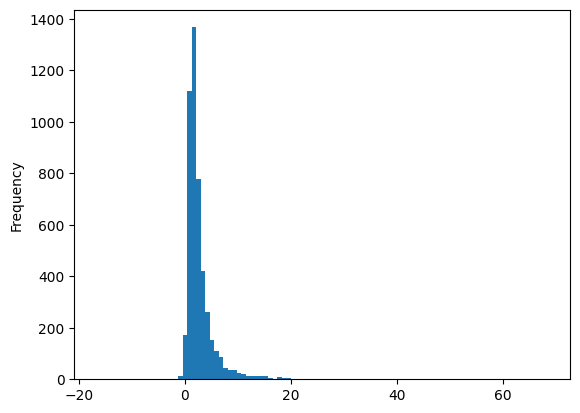

In [24]:
# Plot
ss_df_mp["sur_growth_ba_prc_yr"].plot(kind="hist", bins=100)

In [25]:
# Attach prefix
xxx = ss_df_mp.add_prefix("ss_").rename(
    columns={"ss_group_id": "group_id", "ss_idp": "idp"}
)
xxx.head()

,idp,ss_n_plots,ss_n_ini,ss_n_sur,ss_n_fin,ss_n_rec,ss_n_die,ss_ba_at_v1_of_alive_trees,ss_ba_at_v2_of_alive_trees,ss_ba_at_v1_of_survived,...,ss_tot_growth_ba_prc_yr_hoshino,ss_sur_growth_ba_prc_yr_hoshino,ss_tot_growth_ba_yr,ss_sur_growth_ba_yr,ss_mort_ba_yr_v1,ss_mort_ba_yr_v2,ss_tot_growth_ba_prc_yr,ss_sur_growth_ba_prc_yr,ss_mort_ba_prc_yr_v1,ss_mort_ba_prc_yr_v2
0,500137,1,1,1,1,0,0,0.441355,0.554835,0.441355,...,4.576414,4.576414,0.022696,0.022696,0.0,0.0,5.142332,5.142332,0.0,0.0
0,500214,1,1,1,1,0,0,27.186905,29.109171,27.186905,...,1.366357,1.366357,0.384453,0.384453,0.0,0.0,1.414111,1.414111,0.0,0.0
0,500284,1,1,1,1,0,0,0.895274,1.095890,0.895274,...,4.043845,4.043845,0.040123,0.040123,0.0,0.0,4.481666,4.481666,0.0,0.0
0,500331,1,1,1,1,0,0,36.232861,39.199545,36.232861,...,1.573974,1.573974,0.593337,0.593337,0.0,0.0,1.637566,1.637566,0.0,0.0
0,500653,1,1,1,1,0,0,6.332574,7.718242,6.332574,...,3.957598,3.957598,0.277134,0.277134,0.0,0.0,4.376320,4.376320,0.0,0.0


In [26]:
xxx_nonas = xxx.dropna(subset=["ss_mort_ba_prc_yr_v1"])
xxx_nonas
xxx_nonas_nozeros = xxx_nonas[xxx_nonas["ss_mort_ba_prc_yr_v1"] != 0]
xxx_nonas_nozeros
xxx_nonas_nozeros_no20s = xxx_nonas_nozeros[
    xxx_nonas_nozeros["ss_mort_ba_prc_yr_v1"] != 20
]
display(xxx_nonas_nozeros_no20s)
xxx_nonas_nozeros_no20s["ss_mort_ba_prc_yr_v1"].value_counts().sort_index()

,idp,ss_n_plots,ss_n_ini,ss_n_sur,ss_n_fin,ss_n_rec,ss_n_die,ss_ba_at_v1_of_alive_trees,ss_ba_at_v2_of_alive_trees,ss_ba_at_v1_of_survived,...,ss_tot_growth_ba_prc_yr_hoshino,ss_sur_growth_ba_prc_yr_hoshino,ss_tot_growth_ba_yr,ss_sur_growth_ba_yr,ss_mort_ba_yr_v1,ss_mort_ba_yr_v2,ss_tot_growth_ba_prc_yr,ss_sur_growth_ba_prc_yr,ss_mort_ba_prc_yr_v1,ss_mort_ba_prc_yr_v2
0,501554,1,13,12,12,0,1,35.418238,38.295760,34.703316,...,1.970079,1.970079,0.718489,0.718489,0.142984,0.142984,2.070375,2.070375,0.403703,0.366526
0,502343,1,4,2,2,0,1,35.135755,23.857086,21.958732,...,1.658328,1.658328,0.379671,0.379671,1.328037,1.369862,1.729019,1.729019,3.779731,4.461163
0,502856,1,10,8,8,0,2,57.190134,55.447005,51.230422,...,1.581883,1.581883,0.843316,0.843316,1.191942,1.191942,1.646124,1.646124,2.084175,1.941062
0,502874,1,7,6,6,0,1,60.314879,43.101221,40.160475,...,1.413360,1.413360,0.588149,0.588149,4.030881,4.103508,1.464498,1.464498,6.683062,6.450154
0,503379,1,10,8,8,0,1,13.165269,15.003641,12.334436,...,3.917958,3.917958,0.533841,0.533841,0.088271,0.088271,4.328054,4.328054,0.670484,0.571519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1130924,1,3,2,2,0,1,2.800112,2.841857,2.459268,...,2.891878,2.891878,0.076518,0.076518,0.068169,0.062644,3.111404,3.111404,2.434506,1.985500
0,1131093,1,3,2,2,0,1,3.639862,1.543961,1.420523,...,1.666516,1.666516,0.024688,0.024688,0.443868,0.443868,1.737917,1.737917,12.194633,11.794645
0,1131233,1,4,3,3,0,1,11.391338,11.855575,10.949983,...,1.589207,1.589207,0.181119,0.181119,0.088271,0.077896,1.654053,1.654053,0.774896,0.636140
0,1131278,1,5,4,4,0,1,52.570699,56.237545,52.296726,...,1.453016,1.453016,0.788164,0.788164,0.054794,0.054794,1.507100,1.507100,0.104230,0.096962


ss_mort_ba_prc_yr_v1
0.057283     1
0.071199     1
0.076223     1
0.080427     1
0.088291     1
            ..
18.046798    1
18.061745    1
19.388243    1
19.479319    1
19.890448    1
Name: count, Length: 1651, dtype: int64

In [27]:
df_mp = df_mp.rename(columns={"group_id": "idp"})

In [30]:
merged = xxx_nonas_nozeros_no20s.merge(df_mp, how="left", on="idp")
for col in merged.columns:
    print(col)

idp
ss_n_plots
ss_n_ini
ss_n_sur
ss_n_fin
ss_n_rec
ss_n_die
ss_ba_at_v1_of_alive_trees
ss_ba_at_v2_of_alive_trees
ss_ba_at_v1_of_survived
ss_ba_at_v2_of_survived
ss_ba_at_v1_of_died
ss_ba_at_v2_of_died
ss_ba_at_v2_of_recruited
ss_mort_stems_prc_yr_esq
ss_mort_stems_prc_yr_hoshino
ss_rec_stems_prc_yr_hoshino
ss_mort_ba_prc_yr_hoshino
ss_tot_growth_ba_prc_yr_hoshino
ss_sur_growth_ba_prc_yr_hoshino
ss_tot_growth_ba_yr
ss_sur_growth_ba_yr
ss_mort_ba_yr_v1
ss_mort_ba_yr_v2
ss_tot_growth_ba_prc_yr
ss_sur_growth_ba_prc_yr
ss_mort_ba_prc_yr_v1
ss_mort_ba_prc_yr_v2
n_species_espar_red
n_species_species_lat
n_species_genus_lat
allspecies_htot_mean
allspecies_age13_mean
allspecies_ir5_mean
allspecies_v_mean
allspecies_ba_1_mean
allspecies_ba_2_mean
allspecies_ba_change_perc_yr_mean
allspecies_htot_std
allspecies_age13_std
allspecies_ir5_std
allspecies_v_std
allspecies_ba_1_std
allspecies_ba_2_std
allspecies_ba_change_perc_yr_std
allspecies_htot_range
allspecies_age13_range
allspecies_ir5_range
al

0.5149061330315192

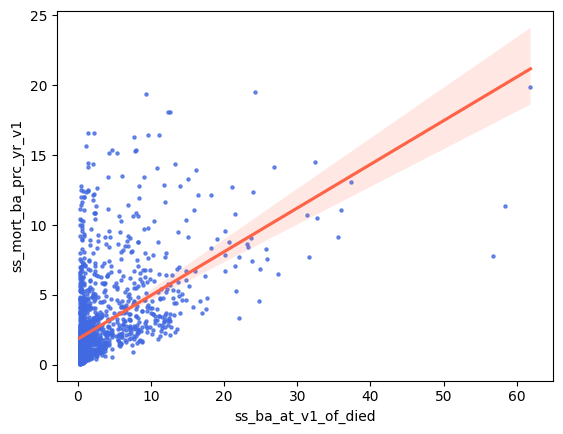

In [71]:
from statistics import correlation
from numpy import corrcoef


y = "ss_mort_ba_prc_yr_v1"
x = "ss_ba_at_v1_of_died"

ttt = merged.copy()
ttt[x].replace(0, np.nan, inplace=True)
ttt[y].replace(0, np.nan, inplace=True)
ttt = ttt.dropna(subset=x)
ttt = ttt.dropna(subset=y)


sns.regplot(
    data=ttt,
    x=x,
    y=y,
    scatter_kws={"color": "royalblue", "alpha": 0.75, "s": 5},
    line_kws={"color": "tomato"},
    # lowess=True,
)

correlation(ttt[x], ttt[y])

---


In [ ]:
# Calculation of Growth / Mortality at plot-level

if "nfi_agg" not in globals() or user_input["rerun_calculation_growth_mortality"]:
    # Load pre-calculated dataframe
    nfi_agg = pd.read_parquet("nfi-idp_level_aggregated_growth_mortality.parquet")

    if (
        nfi_agg.shape[0] != nfi_final_data["idp"].nunique()
        or user_input["rerun_calculation_growth_mortality"]
    ):
        # ⚠️  This takes abnfi_agg 30 minutes to run, so loading the data from the feather file instead
        #     Plus, for some reason, after running this cell, the notebook slows down massively.

        if nfi_agg.shape[0] != nfi_final_data["idp"].nunique():
            print(
                "Number of rows in nfi_agg is not equal to number of rows in nfi_final_data, so re-running the calculation."
            )
            print("Shape of old nfi_agg:", nfi_agg.shape)

        grouped = nfi_final_data.groupby("idp", as_index=False)
        df_list = [group for name, group in grouped]

        # df_list = df_list[:100] # For debug, reduce number to 100 sites only

        nfi_agg = run_mp(
            calculate_growth_mortality,
            df_list,
            combine_func=pd.concat,
            progress_bar=True,
            num_cores=10,
        )

        # Save data
        nfi_agg.to_parquet("nfi-idp_level_aggregated_growth_mortality.parquet")

        # Create Report
        if run_reports_minor:
            profile = ProfileReport(
                nfi_agg.sort_index(axis=1),
                minimal=True,
                dark_mode=True,
                title="Overview of Growth and Mortality Calculations",
            )

            profile.to_file(f"report-growth_mortality_calculations.html")

print("Shape of final nfi_agg:", nfi_agg.shape)
print("Number of individual sites:", nfi_agg["idp"].nunique())

# for col in nfi_agg.columns:
#     print(col)

### Filter sites post-aggregation


In [ ]:
# Remove sites with too few trees
print(f"Number of sites before subsetting: {rf_data_raw['idp'].nunique()}")

if user_input["subset_nfi"]:
    # Mintrees
    # nfi_at_location_level = nfi_at_location_level.query(
    #     "n_ini >= @user_input['subset_min_trees_per_plot']"
    # )

    # # Write information to file
    # write_txt(
    #     f"{current_dir}/_subsetted_to_min_trees_per_plot>{user_input['subset_min_trees_per_plot']}.txt"
    # )

    # Height
    # above_or_below = "below"
    # mymedian = nfi_at_location_level["top1_species_htot_mean"].median()

    # if above_or_below == "above":
    #     nfi_at_location_level = nfi_at_location_level.query(
    #         "top1_species_htot_mean >= @mymedian"
    #     )
    #     write_txt(f"{current_dir}/_subsetted_to_above_median_height.txt")
    # else:
    #     nfi_at_location_level = nfi_at_location_level.query(
    #         "top1_species_htot_mean <= @mymedian"
    #     )
    #     write_txt(f"{current_dir}/_subsetted_to_below_median_height.txt")
    df_subsetted_sites = nfi_agg.copy()
else:
    print("Not subsetting nfi data.")
    df_subsetted_sites = nfi_agg.copy()


print(f"Number of sites after subsetting: {nfi_agg['idp'].nunique()}")

### Merge NFI and Mortality Datasets


In [ ]:
# Attach growth/mortality data to nfi_final_data
nfi_merged = nfi_final_data.merge(nfi_agg, how="left", left_on="idp", right_on="idp")
print("Shape of nfi_merged:", nfi_merged.shape)

### Check against Excel file


In [ ]:
# Check which variables are part documented in the google sheets:

# Load original NFI Variables
nfi_org = pd.read_excel(
    here("docs/ifna_predictor_database.xlsx"),
    sheet_name="NFI Original Variables",
)[["var", "type", "level", "remove"]]

# Load my NFI derivatives
nfi_derivatives = (
    pd.read_excel(
        here("docs/ifna_predictor_database.xlsx"),
        sheet_name="NFI Derivatives",
    )
    .reset_index()[["var", "type", "level", "remove"]]
    .dropna(subset=["type"])
)

# Add suffixes _1 and _2 to the original variables to distinguish them if sampled from different years
suffix_1 = nfi_org.copy()
suffix_2 = nfi_org.copy()

suffix_1["var"] = suffix_1["var"].apply(lambda x: x + "_1")
suffix_2["var"] = suffix_2["var"].apply(lambda x: x + "_2")

# Get list with suffixes for later use
nfi_org_with_suffixes = pd.concat([nfi_org, suffix_1, suffix_2])

# Concatenate original variables with suffixes and derivatives
vars_described_in_sheet = pd.concat([nfi_org, suffix_1, suffix_2, nfi_derivatives])
# vars_described_in_sheet

# Extract variables that are in the final wrangled nfi dataset
final_vars = nfi_merged.columns.to_frame(index=False, name="var").sort_values("var")

# Remove all variables that can be found in the excel file:
mask = final_vars["var"].isin(vars_described_in_sheet["var"])
not_described_vars = final_vars[~mask]

# Print output
print("Variables that are not documented in the excel (should show empty dataframe):")
display(not_described_vars)

# Check if variables are described in the excel file that are not in the final wrangled nfi dataset
# Extract all derivatives
all_ders = nfi_derivatives["var"]

# Find entries in var that are in all_ders but not in final_vars
mask = nfi_derivatives["var"].isin(final_vars["var"])
documented_but_not_in_final_df = nfi_derivatives[~mask]

# Print the output
print("Variables that are documented in the excel but not in the merged nfi dataframe:")
display(documented_but_not_in_final_df.reset_index(drop=True))

# vars_described_in_sheet holds all possible suffix combinations but those are not needed.
# So, reduce vars_described_in_sheet to match variables in df_tmp
vars_described_in_sheet_and_in_df = vars_described_in_sheet[
    vars_described_in_sheet["var"].isin(df_tmp.columns)
]

### Get NFI Variable Encoding


In [ ]:
# DATETIME VARIABLES
# TODO: dropping datetime variable for now because it is of little importance and
# TODO: encoding takes significant extra work for now...
# TODO: To keep circular nature of data structure, encode using trigonometric functions
# TODO: https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html

# Rerun this to avoid errors:
vars_described_in_sheet_and_in_df = vars_described_in_sheet[
    vars_described_in_sheet["var"].isin(df_tmp.columns)
]

date_cols = vars_described_in_sheet_and_in_df.query("type == 'date'")["var"].tolist()

for var in date_cols:
    df_tmp[var] = df_tmp[var].fillna(df_tmp["campagne_1"].astype(str) + "-07-01")

df_tmp = df_tmp.drop(columns=date_cols)
print(f"Shape of df_tmp: {df_tmp.shape} after dropping date columns: {date_cols}")

In [ ]:
# ENCODE CATEGORICAL VARIABLES

# vars_described_in_sheet holds all possible suffix combinations but those are not needed.
# So, reduce vars_described_in_sheet to match variables in df_tmp
vars_described_in_sheet_and_in_df = vars_described_in_sheet[
    vars_described_in_sheet["var"].isin(df_tmp.columns)
]

# Get list of variables to encode, based on excel file
vars_to_ohe = vars_described_in_sheet_and_in_df.query("type == 'cat'")["var"]

# Reduce to have only variables in df_tmp
vars_to_ohe = [var for var in vars_to_ohe if var in df_tmp.columns]

df_encoded = df_tmp.copy()
print(f"Shape of df_encoded: {df_encoded.shape}")

### Reduce data to location-level


In [ ]:
# Get temporary df
df_tmp = df_encoded.copy()
print(f"Shape of df_encoded: {df_encoded.shape}")
print("Number of individual sites:", df_tmp["idp"].nunique())

# Get all variables on location-level
location_vars = vars_described_in_sheet_and_in_df.query(
    "level == 'location' or level == 'grouping'"
)
tree_vars = vars_described_in_sheet_and_in_df.query("level == 'tree'")

print("Number of tree-level variables that are removed:", tree_vars.shape[0])
print("Number of location-level variables that are kept:", location_vars.shape[0])

# Get all columns in nfi_final_data that are also in location_vars
matching_columns = [var for var in location_vars["var"] if var in df_tmp.columns]
# matching_columns = [var for var in location_vars["var"]]

# Fixes by hand because some integers are saved as floats
# sver
df_tmp["sver"] = df_tmp["sver"].replace("0.0", "0")
df_tmp["sver"] = df_tmp["sver"].replace("1.0", "1")
df_tmp["sver"] = df_tmp["sver"].replace("2.0", "2")
df_tmp["sver"] = df_tmp["sver"].replace("3.0", "3")
df_tmp["sver"] = df_tmp["sver"].replace("4.0", "4")
df_tmp["sver"] = df_tmp["sver"].replace("5.0", "5")
df_tmp["sver"] = df_tmp["sver"].replace("6.0", "6")
df_tmp["instp5"] = df_tmp["instp5"].replace("0.0", "0")
df_tmp["uta1"] = df_tmp["sver"].replace("6.0", "6")

# Reduce nfi_final_data to only contain location-level variables
nfi_at_location_level = df_tmp[matching_columns].drop_duplicates()

# Print all variables that were removed
print("\n")
print("Variables that were removed because they are undocumented:")
counter = 0
for var in df_encoded.columns:
    if var not in nfi_at_location_level.columns:
        if var not in tree_vars["var"].to_list():
            counter = counter + 1
            print(f" {counter}. {var}")

print("\n")
print("Variables that were removed because they are on tree-level:")
counter = 0
for var in df_encoded.columns:
    if var not in nfi_at_location_level.columns:
        if var in tree_vars["var"].to_list():
            counter = counter + 1
            print(f" {counter}. {var}")

print("\n")
print(
    f"❌ not working ❌ Final dataframe should have {df_encoded.shape[1] - len(tree_vars) - counter} columns:"
)
print("Shape of nfi_at_location_level:", nfi_at_location_level.shape)

In [ ]:
# Algorithm to search for idp duplicates in the dataset
if nfi_at_location_level.shape[0] != df_encoded["idp"].nunique():
    print(
        f"Number of rows in df_tmp ({nfi_at_location_level.shape[0]}) is not equal to number of rows in df_encoded ({df_encoded['idp'].nunique()}), so running search for duplicated idp to find issue:."
    )

    all_idps = nfi_at_location_level["idp"].to_list()
    counter = 0
    double_idps = []

    for i in range(0, len(all_idps)):
        for j in range(i + 1, len(all_idps)):
            if all_idps[i] == all_idps[j]:
                print(all_idps[j])
                counter = counter + 1
                double_idps.append(all_idps[j])

    print(f"counter of duplicated idps: {counter}")

    idp_x = double_idps[1]
    # idp_x = "722345"
    xxx = df_tmp.query("idp == @idp_x")

    print(idp_x)

    for col in xxx.columns:
        if xxx[col].nunique() > 1:
            # xxx[col] = xxx[col].astype(int)
            print(xxx[col])
            # print(xxx[col].iloc[0] == xxx[col].iloc[1])
else:
    print("No duplicates found when reducing to location-level variables.")

## Add Data to Target


In [ ]:
# Get target only dataframe and save it separately
df_target = nfi_at_location_level.copy()[["idp", user_input["target"]]]
# Get df to which data is added sequentially
df_target_and_data = df_target.copy()

### NFI Data


#### Original Data


In [ ]:
# Note opposite logic: If data is to be added, the cell is NOT executed
df_org = df_target_and_data
if user_input["add_nfi_original"]:
    # Keep only variables not pre-set to be removed
    add_these = nfi_org_with_suffixes.query("remove != 'x'")["var"].to_list()
    # Make sure "idp" is kept
    add_these = (
        add_these
        + ["idp"]
        + user_input["test_train_strata"]
        + [user_input["add_target_0s_strata"]]
    )
    add_these = [var for var in add_these if var in nfi_at_location_level.columns]
    add_these = set(add_these)
    add_these = sorted(add_these)

    # Merge data
    df_target_and_data = df_target_and_data.merge(
        nfi_at_location_level[add_these],
        how="left",
        left_on="idp",
        right_on="idp",
    )

    # display(df_target_and_data)

    # Print merge information
    print(
        f"Information on adding original NFI variables:",
        f"\n - Dataset before merging had shape: {df_org.shape}",
        f"\n - Dataset after merging has shape:  {df_target_and_data.shape}",
        f"\n - The following {df_target_and_data.shape[1] - df_org.shape[1]} features were added: {' | '.join(add_these)}",
    )

else:
    print("No original NFI variables added.")

#### Derived Data


In [ ]:
df_org = df_target_and_data
if user_input["add_nfi_derivatives"]:
    # Keep only variables not pre-set to be removed
    add_these = nfi_derivatives.query("remove != 'x'")["var"].to_list()
    # Make sure "idp" is kept
    add_these = (
        add_these
        + ["idp"]
        + user_input["test_train_strata"]
        + [user_input["add_target_0s_strata"]]
    )
    add_these = [var for var in add_these if var in nfi_at_location_level.columns]
    add_these = sorted(add_these)
    add_these = sorted(add_these)

    # Do not add variables that are already in the dataset
    add_these = [var for var in add_these if var not in df_target_and_data.columns]
    # ... except for idp
    if "idp" not in add_these:
        add_these = add_these + ["idp"]

    # Merge data
    df_target_and_data = df_target_and_data.merge(
        nfi_at_location_level[add_these],
        how="left",
        left_on="idp",
        right_on="idp",
    )

    # display(df_target_and_data)

    # Print merge information
    print(
        f"Information on adding derived NFI variables:",
        f"\n - Dataset before merging had shape: {df_org.shape}",
        f"\n - Dataset after merging has shape:  {df_target_and_data.shape}",
        f"\n - The following {df_target_and_data.shape[1] - df_org.shape[1]} features were added: {' | '.join(add_these)}",
    )

else:
    print("No derived NFI variables added.")

#### Metrics of Change


### GEE


In [ ]:
nvarsnfi = df_target_and_data.shape
gee_vars = []

if user_input["add_gee_data"]:
    if "gee_data" not in globals():
        gee_data = pd.read_feather(
            "../02_process_gee_data/final_gee_predictor_dataset.feather"
        )

    missing_idp_in_gee = list(
        set(df_target_and_data["idp"].unique()) - set(gee_data["idp"].unique())
    )

    if len(missing_idp_in_gee) > 0:
        print(
            f"❌ {len(missing_idp_in_gee)} idp's are in df_target_and_data but not in gee_data\n\t{missing_idp_in_gee}:\n",
        )

    nvarsgee = gee_data.shape[1] - 1  # minus one for idp

    df_target_and_data_with_gee = df_target_and_data.merge(
        gee_data, how="left", left_on="idp", right_on="idp"
    )

    print(
        f" - Shape of gee_data: {gee_data.shape}",
        f"\n - Adding {nvarsgee} columns = {nvarsgee + nvarsnfi[1]} columns in total.",
    )

    # Get all new columns:
    new_cols = df_target_and_data_with_gee.columns.to_list()
    new_cols = [
        col for col in new_cols if col not in df_target_and_data.columns.to_list()
    ]
    print(f" - New columns: {new_cols}")

    df_target_and_data = df_target_and_data_with_gee.copy()

    gee_vars = [var for var in gee_data.columns if var in df_target_and_data.columns]
    print(f" - These gee variables were added: {gee_vars}")

else:
    print("Not adding gee data.")
    gee_vars = []
    df_target_and_data_with_gee = df_target_and_data.copy()

print(
    f"\nShape of before adding gee:\t {nvarsnfi}",
    f"\nShape of after adding gee:\t {df_target_and_data_with_gee.shape}",
)

### Soil (RMQS)


In [ ]:
nvarsnfi = df_target_and_data.shape

if user_input["add_rmqs_data"]:
    if "rmqs_data" not in globals():
        rmqs_data = pd.read_feather("../03_process_france_data/data_rmqs.feather").drop(
            columns=["id_site", "date_compl", "code_dept"], errors="ignore"
        )

    missing_idp_in_rmqs = list(
        set(df_target_and_data["idp"].unique()) - set(rmqs_data["idp"].unique())
    )
    print(
        f"Site idp that are in df_target_and_data but not in rmqs_data {len(missing_idp_in_rmqs)}: {missing_idp_in_rmqs}\n",
    )

    nvarsrmqs = rmqs_data.shape[1] - 1  # minus one for idp

    df_target_and_data_with_rmqs = df_target_and_data.merge(
        rmqs_data, how="left", left_on="idp", right_on="idp"
    )

    print(
        f"Shape of rmqs_data: {rmqs_data.shape}",
        f"\nAdding {nvarsrmqs} columns = {nvarsrmqs + nvarsnfi[1]} columns in total.",
    )

    # Get all new columns:
    new_cols = df_target_and_data_with_rmqs.columns.to_list()
    new_cols = [
        col for col in new_cols if col not in df_target_and_data.columns.to_list()
    ]
    print(f"New columns: {new_cols}")

    df_target_and_data = df_target_and_data_with_rmqs.copy()
else:
    print("Not adding rmqs data.")
    df_target_and_data_with_rmqs = df_target_and_data.copy()

print(
    f"\nShape of before adding rmqs:\t {nvarsnfi}",
    f"\nShape of after adding rmqs:\t {df_target_and_data_with_rmqs.shape}",
)

### EDO


In [ ]:
nvarsnfi = df_target_and_data.shape

if user_input["add_edo_data"]:
    if "edo_data" not in globals():
        edo_data = pd.read_feather("../03_process_france_data/data_edo_all.feather")

    missing_idp_in_edo = list(
        set(df_target_and_data["idp"].unique()) - set(edo_data["idp"].unique())
    )
    print(
        f"Site idp that are in df_target_and_data but not in edo_data {len(missing_idp_in_edo)}: {missing_idp_in_edo}\n",
    )

    nvarsedo = edo_data.shape[1] - 1  # minus one for idp

    df_target_and_data_with_edo = df_target_and_data.merge(
        edo_data, how="left", left_on="idp", right_on="idp"
    )

    print(
        f"Shape of edo_data: {edo_data.shape}",
        f"\nAdding {nvarsedo} columns = {nvarsedo + nvarsnfi[1]} columns in total.",
    )

    # Get all new columns:
    new_cols = df_target_and_data_with_edo.columns.to_list()
    new_cols = [
        col for col in new_cols if col not in df_target_and_data.columns.to_list()
    ]
    print(f"New columns: {new_cols}")

    df_target_and_data = df_target_and_data_with_edo.copy()
else:
    print("Not adding edo data.")
    df_target_and_data_with_edo = df_target_and_data.copy()

print(
    f"\nShape of before adding edo:\t {nvarsnfi}",
    f"\nShape of after adding edo:\t {df_target_and_data_with_edo.shape}",
)

### Agroparistech


In [ ]:
nvarsnfi = df_target_and_data.shape

if user_input["add_apt_data"]:
    if "apt_data" not in globals():
        apt_data = pd.read_feather(
            "../03_process_france_data/data_agroparistech_all.feather"
        )

    missing_idp_in_apt = list(
        set(df_target_and_data["idp"].unique()) - set(apt_data["idp"].unique())
    )
    print(
        f"Site idp that are in df_target_and_data but not in apt_data {len(missing_idp_in_apt)}: {missing_idp_in_apt}\n",
    )

    nvarsapt = apt_data.shape[1] - 1  # minus one for idp

    df_target_and_data_with_apt = df_target_and_data.merge(
        apt_data, how="left", left_on="idp", right_on="idp"
    )

    print(
        f"Shape of apt_data: {apt_data.shape}",
        f"\nAdding {nvarsapt} columns = {nvarsapt + nvarsnfi[1]} columns in total.",
    )

    # Get all new columns:
    new_cols = df_target_and_data_with_apt.columns.to_list()
    new_cols = [
        col for col in new_cols if col not in df_target_and_data.columns.to_list()
    ]
    print(f"New columns: {new_cols}")

    df_target_and_data = df_target_and_data_with_apt.copy()
else:
    print("Not adding apt data.")
    df_target_and_data_with_apt = df_target_and_data.copy()

print(
    f"\nShape of before adding apt:\t {nvarsnfi}",
    f"\nShape of after adding apt:\t {df_target_and_data_with_apt.shape}",
)

### Altimetry


In [ ]:
nvarsnfi = df_target_and_data.shape

if user_input["add_dem_data"]:
    if "dem_data" not in globals():
        dem_data = pd.read_feather(
            "../03_process_france_data/data_altimetry_all.feather"
        )

    missing_idp_in_apt = list(
        set(df_target_and_data["idp"].unique()) - set(dem_data["idp"].unique())
    )
    print(
        f"Site idp that are in df_target_and_data but not in dem_data {len(missing_idp_in_apt)}: {missing_idp_in_apt}\n",
    )

    nvarsapt = dem_data.shape[1] - 1  # minus one for idp

    df_target_and_data_with_dem = df_target_and_data.merge(
        dem_data, how="left", left_on="idp", right_on="idp"
    )

    print(
        f"Shape of dem_data: {dem_data.shape}",
        f"\nAdding {nvarsapt} columns = {nvarsapt + nvarsnfi[1]} columns in total.",
    )

    # Get all new columns:
    new_cols = df_target_and_data_with_dem.columns.to_list()
    new_cols = [
        col for col in new_cols if col not in df_target_and_data.columns.to_list()
    ]
    print(f"New columns: {new_cols}")

    new_cols = df_target_and_data_with_dem.columns.to_list()

    df_target_and_data = df_target_and_data_with_dem.copy()
else:
    print("Not adding apt data.")
    df_target_and_data_with_dem = df_target_and_data.copy()

print(
    f"\nShape of before adding apt:\t {nvarsnfi}",
    f"\nShape of after adding apt:\t {df_target_and_data_with_dem.shape}",
)

### Quality Control


In [ ]:
df_pre_qc = df_target_and_data.copy()

In [ ]:
# Check if stratification variables need to be added
add_strata = False
for strata in user_input["test_train_strata"]:
    if strata not in df_pre_qc.columns:
        print(f"❗ {strata} was not in df_target_and_data. Attaching them now...")
        add_strata = True
if add_strata:
    df_post_qc = df_pre_qc.merge(
        nfi_at_location_level[["idp"] + user_input["test_train_strata"]],
        how="left",
        left_on="idp",
        right_on="idp",
    )

else:
    df_post_qc = df_pre_qc.copy()

print(f"\nShape of df_pre_qc:  {df_pre_qc.shape}")
print(f"Shape of df_post_qc: {df_post_qc.shape}")

In [ ]:
# Check that no idp is duplicated
if sum(df_post_qc["idp"].value_counts() > 1) > 0:
    raise SystemError("There are duplicated idp's in the dataset.")

In [ ]:
# Report on shapes of nfi without data and with data
print(
    f"\nShape of nfi_at_location_level: {df_target.shape}",
    f"\nShape of df_post_qc: {df_post_qc.shape}",
    f"\nA total of {df_post_qc.shape[1] - df_target.shape[1]} columns were added.",
)

print("All columns in df_post_qc and their type:")
for i, col in enumerate(df_post_qc.columns):
    print(f" {i:<5} {df_post_qc[col].dtype:}\t {col}")

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def calculate_r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2


def create_scatterplots(target, dataframe, subfolder, verbose=False):
    # Create the subfolder if it doesn't exist
    if verbose:
        print(f"Creating subfolder {subfolder} if it doesn't exist...")
    subfolder = f"{subfolder}"
    os.makedirs(subfolder, exist_ok=True)

    # Get the list of variables in the dataframe
    variables = dataframe.columns

    # Initialize an empty dataframe to store correlation values
    correlation_table = pd.DataFrame(
        columns=["Target_Variable", "Predictor_Variable", "Pearson_Correlation"]
    )

    # Ignore the specific warning when smoother fails
    warnings.filterwarnings(
        "ignore", category=RuntimeWarning, message="invalid value encountered in divide"
    )
    warnings.filterwarnings(
        "ignore",
        category=RuntimeWarning,
        message="divide by zero encountered in divide",
    )

    # Loop through each variable
    for variable in variables:
        if verbose:
            print(
                f"\n - {variables.get_loc(variable)+1}/{len(variables)}: \t {variable}",
                end="",
            )
        # Check if variable has only NA values
        if dataframe[variable].isna().sum() > (0.8 * len(dataframe[variable])):
            if verbose:
                print(f"\t | {variable} has > 80% NA values. Skipping...", end="")
            # Write information to file
            with open(f"{subfolder}/_skipped_variables.txt", "a") as file:
                file.write(f"{variable}\t has only NA values. Skipping...\n")
            continue

        if variable != target:
            # Density plot for numerical variables
            if pd.api.types.is_numeric_dtype(dataframe[variable]):
                try:
                    # Start figure
                    plt.figure(figsize=(12, 6))
                    # Add density plot
                    sns.kdeplot(
                        data=dataframe,
                        x=variable,
                        y=target,
                        fill=True,
                        cmap="mako",
                        levels=100,
                        warn_singular=False,
                    )
                    # Add smoother
                    sns.regplot(
                        x=variable,
                        y=target,
                        data=dataframe,
                        lowess=True,
                        color="tomato",
                        scatter_kws={"color": "royalblue", "alpha": 0.75, "s": 5},
                        line_kws={"color": "tomato"},
                    )
                    # Add title
                    plt.title(f"{target} ~ {variable}")
                    # Calculate Pearson correlation coefficient
                    r = round(
                        np.corrcoef(dataframe[target], dataframe[variable])[0, 1], 2
                    )
                    # Add values to the correlation table dataframe
                    correlation_table = pd.concat(
                        [
                            correlation_table,
                            pd.DataFrame(
                                {
                                    "Target_Variable": [target],
                                    "Predictor_Variable": [variable],
                                    "Pearson_Correlation": [r],
                                }
                            ),
                        ],
                    ).reset_index(drop=True)
                    plt.text(
                        0.5,
                        0.95,
                        f"pearson-r: {r:.2f}",
                        transform=plt.gca().transAxes,
                        fontsize=10,
                        verticalalignment="top",
                    )
                    # Save the figure
                    plt.savefig(os.path.join(f"{subfolder}/{variable}.png"))
                    plt.close()

                # If density plot caused error, then plot scatterplot
                except ValueError as e:
                    if verbose:
                        print(
                            f"Making only scatterplot because of error plotting {target} ~ {variable}: {e}"
                        )
                    plt.figure(figsize=(12, 6))
                    sns.scatterplot(x=variable, y=target, data=dataframe, s=5)
                    plt.title(f"{target} ~ {variable}")
                    plt.savefig(os.path.join(f"{subfolder}/{variable}.png"))
                    plt.close()

            # If not numerical, then plot violin plot
            elif pd.api.types.is_object_dtype(dataframe[variable]):
                plt.figure(figsize=(12, 6))
                sns.violinplot(x=variable, y=target, data=dataframe)
                plt.title(f"{target} ~ {variable}")
                plt.savefig(os.path.join(f"{subfolder}/{variable}.png"))
                plt.close()

    # Save the correlation table dataframe as a CSV file
    correlation_table = correlation_table.sort_values("Pearson_Correlation")
    correlation_table.to_csv(
        os.path.join(subfolder, f"_correlation_table.csv"), index=False
    )

    # Reset warnings to default behavior
    warnings.resetwarnings()

    # return correlation_table

---

# 🌲 Random Forest


## ⚙️ Data Cleaning


In [ ]:
rf_data_raw = df_post_qc.copy()
print("Shape of rf_data_raw:", rf_data_raw.shape)

### 🛑 Add Custom Filter


In [ ]:
# ROWS FILTER
if user_input["target"] == "mort_stems_prc_yr_esq":
    rf_data_raw = rf_data_raw[rf_data_raw[target] != 100]


if user_input["target"] == "mort_ba_prc_yr_v1":
    rf_data_raw = rf_data_raw[rf_data_raw[target] != 20]

print("New shape of rf_data_raw:", rf_data_raw.shape)
print(
    "Number of rows dropped:",
    nfi_at_location_level.shape[0] - rf_data_raw.shape[0],
    " (",
    round(
        (nfi_at_location_level.shape[0] - rf_data_raw.shape[0])
        / nfi_at_location_level.shape[0]
        * 100,
        2,
    ),
    "% )",
)

In [ ]:
# COLUMNS FILTER
col_filter = "none"

if col_filter != "none":
    # Subset code:
    to_keep = [
        "idp",
        target,
        # Selection of vars from a good model:
        "top1_species",
        "top2_species",
        "nincid_2",
        "top3_species",
        "ntrees_1",
        "dom_nr1_tree_class_ba_abs",
        "ntrees_2",
        "gre",
        "site_ba_prc_dead_at_v1",
    ] + test_train_strata

    # Remove duplicates from the list
    to_keep = list(dict.fromkeys(to_keep))

    # Keep only selected variables
    rf_data_raw = rf_data_raw[to_keep]

    # Output
    # print(f"Number of columns removed: {nfi_at_location_level.shape[1] - len(to_keep)}")
    # print(rf_data_raw.shape)
    # print(rf_data_raw.columns)

    # Write information:
    file_path = f"{current_dir}/⚠️_COL_FILTER_{col_filter}.txt"
    with open(file_path, "w") as file:
        file.write(f"{col_filter}")

    print("New shape of rf_data_raw:", rf_data_raw.shape)
    print(
        "Number of rows dropped:",
        nfi_at_location_level.shape[1] - rf_data_raw.shape[1],
        " (",
        round(
            (nfi_at_location_level.shape[1] - rf_data_raw.shape[1])
            / nfi_at_location_level.shape[1]
            * 100,
            2,
        ),
        "% )",
    )

print(f"Shape of rf_data_raw: {rf_data_raw.shape}")

### Filter Rows


#### Remove NAs in Target


In [ ]:
# Get original shape
shape_org = df_subsetted_sites.shape
# Drop rows where target is NA
df_without_nas = df_subsetted_sites.dropna(subset=[target])
# Print information
print(
    f"Dropping NA values in target variable `{target}` reduced the dataset by:",
    f"\n - {shape_org[0] - df_without_nas.shape[0]} rows ({round((shape_org[0] - df_without_nas.shape[0])/shape_org[0]*100, 2)}%)",
    f"\n - Shape changed from {shape_org} to {df_without_nas.shape}",
)

#### Remove 0s in Target


In [ ]:
# Get original shape
shape_org = df_without_nas.shape
# Get copy of data
df_all0s = df_without_nas.copy()
df_no0s = df_without_nas.copy()
# Reduce to have only target 0s
df_all0s = df_all0s[df_all0s[user_input["target"]] == 0]
df_no0s = df_no0s[df_no0s[user_input["target"]] != 0]
# Get fraction of zeros or no zeros
perc_0s = round(df_all0s.shape[0] / shape_org[0] * 100, 2)
perc_no0s = round(df_no0s.shape[0] / shape_org[0] * 100, 2)
# Get fraction of 0-entries that should be kept.
# Percentage is relative to the dataframe without any 0s and NAs
perc_to_add = user_input["add_target_0s_percentage"]
n_rows_to_add = round(perc_to_add * df_no0s.shape[0], 0)

# Print information
print(
    f"👉 Note that this information is AFTER dropping NAs in the target variable `{target}`:\n",
    f" - Dataset with 0 values has shape \t {df_without_nas.shape} (=100%)",
    f"\n  - From this keeping only 0s in target gives shape {df_all0s.shape[0]} ({perc_0s}%)",
    f"\n  - From this removing all 0s in target gives shape {df_no0s.shape[0]} ({perc_no0s}%)",
    f"\n  - Adding {round(perc_to_add*100)}% of NA values equals adding {n_rows_to_add} rows.",
    f"\n  - ❗So the outgoing dataframe should have ~{df_no0s.shape[0] + n_rows_to_add} rows.",
)

if user_input["add_target_0s"]:
    # SAMPLING OF TARGET 0s
    # Do random sampling of 0s
    if user_input["add_target_0s_strata"] == "none":
        print("\n - Adding randomly sampled 0s to the dataset...")
        sample_perc_from_all0s = n_rows_to_add / df_all0s.shape[0]
        df_subset0s = df_all0s.sample(
            frac=sample_perc_from_all0s, random_state=seed_nr, replace=False
        )

    # Do a stratified sampling based on the 'add_target_0s_strata' variable
    if user_input["add_target_0s_strata"] != "none":
        print(
            f"\n - Adding randomly sampled 0s to the dataset based on stratification variable {user_input['add_target_0s_strata']}..."
        )
        # Check if strata variable is in the data
        if user_input["add_target_0s_strata"] not in df_all0s.columns:
            # If strata is not in the nfi data, throw error
            if user_input["add_target_0s_strata"] not in nfi_at_location_level.columns:
                raise SystemExit(
                    f"❌ The requested strata variable `{user_input['add_target_0s_strata']}` is not in the NFI data!"
                )
            # Else, attach strata from nfi data temporarily
            # Print information on behaviour
            print(
                f"   - ❗The strata variable for adding 0s `{user_input['add_target_0s_strata']}` was not in the data but added temporarily for the split."
            )

            # Get tmp df from nfi data with strata
            df_tmp = nfi_at_location_level[
                ["idp", user_input["add_target_0s_strata"]]
            ].rename(columns={user_input["add_target_0s_strata"]: "nfi_strata"})

            if (df_tmp.shape[1]) > 2:
                raise SystemExit(
                    f"❌ Trying to add to many columns! df_tmp has {df_tmp.shape[1]} columns but should only have 2 columns, idp and strata."
                )

            # Get number of rows before merging
            nrows_before = df_all0s.shape[0]
            # Attach strata to df_all0s (which is a subset of df_without_nas!)
            df_all0s = df_all0s.merge(df_tmp, how="left", left_on="idp", right_on="idp")
            # Check if number of rows changed
            nrows_after = df_all0s.shape[0]
            if nrows_before != nrows_after:
                raise SystemExit(
                    f"❌ Number of rows in df_all0s ({nrows_before}) is not equal to number of rows in df_all0s ({nrows_after}) after attaching strata variable from NFI!"
                )
        else:
            # Else, just use the strata variable directly
            df_all0s["nfi_strata"] = df_all0s[user_input["add_target_0s_strata"]]

        # Group by strata
        df_subset0s = df_all0s.groupby("nfi_strata")
        # CHECKS -------------------------------------------------------------------
        # Check if groups hold too little rows to sample evenly across all strata
        n_groups = df_subset0s.ngroups
        n_rows_to_add_per_group = int(round(n_rows_to_add / n_groups, 0))
        # Percentage of groups with less than requested number of rows per group
        perc_undersampled = round(
            (df_subset0s.size() < n_rows_to_add_per_group).sum()
            / df_subset0s.size().shape[0]
            * 100
        )

        if perc_undersampled > 50:
            raise SystemExit(
                f"❌ {perc_undersampled}% of the groups have less than the requested sampling size per group! This is too much, based on a 50% threshold."
            )
        print(
            f"   - ✅ {perc_undersampled}% of the groups have less than the requested sampling size per group."
        )
        # CHECKS -------------------------------------------------------------------
        # Do the sampling:
        df_subset0s = df_subset0s.apply(
            lambda x: x.sample(
                min(n_rows_to_add_per_group, len(x)), random_state=seed_nr
            )
        )
        # Ungroup again
        df_subset0s = df_subset0s.reset_index(drop=True)

        # Remove strata
        df_subset0s = df_subset0s.drop("nfi_strata", axis=1)
        print("   - ✅ Removed strata variable again.")

    # Attach subset to df without 0s
    df_subset0s = pd.concat([df_no0s, df_subset0s], axis=0)

    # Check that there are no idp duplicates created
    if df_subset0s["idp"].nunique() != df_subset0s.shape[0]:
        raise SystemExit(
            f"❌ Number of rows in df_subset0s ({df_subset0s.shape[0]}) is not equal to number of unique idp ({df_subset0s['idp'].nunique()})!"
        )
    else:
        print(
            f"   - ✅ Number of rows in df_subset0s ({df_subset0s.shape[0]}) is equal to number of unique idp ({df_subset0s['idp'].nunique()})!"
        )

    # Falling back to first if statement level
    # Print information
    print(
        f"\nThe original ingoing dataset (no NAs) had the shape\t\t {shape_org}",
        f"\nAfter adding a {round(perc_to_add*100)}% subset of 0s, the dataset has the shape\t {df_subset0s.shape}",
    )

    df_after_row_filter = df_subset0s.copy()

else:
    df_after_row_filter = df_without_nas.copy()[
        df_without_nas[user_input["target"]] != 0
    ]

    print(
        f"\nAll entries where {user_input['target']} == 0 were removed!",
        f"\n - Shape before:\t{df_without_nas.shape}",
        f"\n - Shape after: \t{df_after_row_filter.shape}",
        f"\n - This is a removal of {df_without_nas.shape[0] - df_no0s.shape[0]} rows ({round((df_without_nas.shape[0] - df_no0s.shape[0])/df_without_nas.shape[0]*100, 2)}%)",
    )

#### Subset Percentile


In [ ]:
df_reduced_to_quantile = df_after_row_filter.copy()

In [ ]:
if user_input["reduce_to_percentile"]:
    df_reduced_to_quantile["quantiles"] = split_into_quantiles(
        df_reduced_to_quantile[target], user_input["percentile_n_group"]
    )
    quantile_lvls = sorted(df_reduced_to_quantile["quantiles"].unique())
    keep_this_quantile = quantile_lvls[user_input["percentile_group"]]
    df_reduced_to_quantile = df_reduced_to_quantile[
        df_reduced_to_quantile["quantiles"] == keep_this_quantile
    ]

    df_reduced_to_quantile = df_reduced_to_quantile.drop(columns="quantiles")

    # Report results
    print(
        f"\n - Shape before:\t{df_after_row_filter.shape}",
        f"\n - Shape after: \t{df_reduced_to_quantile.shape}",
        f"\n - Reducing data to percentiles {keep_this_quantile} means a removal of {df_after_row_filter.shape[0] - df_reduced_to_quantile.shape[0]} rows ({round((df_after_row_filter.shape[0] - df_reduced_to_quantile.shape[0])/df_after_row_filter.shape[0]*100, 2)}%)",
    )

In [ ]:
if not user_input["make_classification"]:
    if user_input["reduce_to_percentile"]:
        # Plot original distribution with inputded quantiles
        plot_quantiles(
            df_after_row_filter[user_input["target"]],
            user_input["percentile_n_group"],
            user_input["target"],
            current_dir,
        )

    # Plot distribution of subsetted quantile
    fig, ax = plt.subplots()
    sns.histplot(df_reduced_to_quantile, x=target, ax=ax)
    ax.set_title(f"Final used values for {target}")
    plt.savefig(f"{current_dir}/fig_histogram_{target}_final.png")
    plt.show()
else:
    print("Not plotting histograms because classification is used.")

#### Make Classification


In [ ]:
df_classified = df_reduced_to_quantile.copy()

if user_input["make_classification"]:
    # Plot original distribution with inputded quantiles
    plot_quantiles(
        df_after_row_filter[target],
        user_input["classification_groups"],
        user_input["target"],
        current_dir,
    )

    df_classified[target] = split_into_quantiles(
        df_classified[target], user_input["classification_groups"]
    )

    # Plot distribution of target variable
    plt.figure()
    df_classified[target].value_counts().sort_index().plot(kind="bar")
    plt.title(f"Distribution of classified `{user_input['target']}`")
    plt.savefig(f"{current_dir}/fig_histogram_{target}_classified.png")
    plt.tight_layout()
    plt.show()
else:
    print("No classification of target variable was made.")

In [ ]:
df_for_stratification = df_classified.copy()

#### Plot Correlations


In [ ]:
user_input["do_corr_plots"] = False
# user_input["plot_corr_of_dataset"] = ["nfi", "gee", "edo", "rmqs", "apt", "dem"]
user_input["plot_corr_of_dataset"] = ["nfi"]
df_corr = df_for_stratification.copy()

In [ ]:
if user_input["do_corr_plots"]:
    # CHECK IF TARGET IS CATEGORICAL
    if user_input["make_classification"]:
        # To make classified levels into integers
        # Replace each level with a number and
        # Set the variable to be an integer
        levels = df_corr[target].unique()
        for i in range(len(levels)):
            df_corr[target] = df_corr[target].replace(levels[i], i)
        df_corr[target] = df_corr[target].astype(int)

    # Loop through requested datasets
    for ds in user_input["plot_corr_of_dataset"]:
        display(f"----- Working on {ds}... -----")
        if ds == "nfi":
            df_to_check = nfi_at_location_level.copy()
        if ds == "gee":
            df_to_check = gee_data.copy()
        if ds == "rmqs":
            df_to_check = rmqs_data.copy()
        if ds == "edo":
            df_to_check = edo_data.copy()
        if ds == "apt":
            df_to_check = apt_data.copy()
        if ds == "dem":
            df_to_check = dem_data.copy()

        # Remove target from df_to_check and get colums
        cols = df_to_check.drop(
            columns=[user_input["target"], "idp"], errors="ignore"
        ).columns.tolist() + [user_input["target"]]

        # Subset df_corr to only contain columns in cols
        cols = sorted(cols)
        df_corrplot = df_corr[cols]

        # Save plots
        dir_tmp = current_dir + "/corr_plots/" + ds
        create_scatterplots(user_input["target"], df_corrplot, dir_tmp, verbose=False)

In [ ]:
# This cell exists just to easier run from top to here

#### Check Stratifcation Distribution

- How to do this the right way: Sequential call for split and cvfolding
- Then, record what strata were aggregated
- Then in the end, take the initial dataframe again and aggregate the strata


In [ ]:
if len(user_input["test_train_strata"]) > 0:
    df_aggregated_strata = aggregate_strata_with_too_little_obs(
        Xy_in=df_for_stratification.copy(),
        strata_vars=user_input["test_train_strata"],
        do_fold_too=True,
        split_test=user_input["test_split"],
        cv_fold=user_input["cv_folds"],
        seed_nr=user_input["seed_nr"],
    )

    display(f"Shape of df_aggregated_strata: {df_aggregated_strata.shape}")
else:
    df_aggregated_strata = df_for_stratification.copy()
    print("No strata variables specified, so not aggregating strata.")

### Filter Columns


#### based on Excel sheet


In [ ]:
df_before_dropping_cols = df_aggregated_strata.copy()

In [ ]:
# EXCEL-BASED COLUMN REMOVAL
df_tmp = df_before_dropping_cols.copy()

# Remove columns that are not needed as specified
columns_to_remove = vars_described_in_sheet_and_in_df.query("remove == 'x'")[
    "var"
].to_list()

# Make sure that idp is only removed before running the random forest
if "idp" in columns_to_remove:
    columns_to_remove.remove("idp")

columns_to_remove = sorted(columns_to_remove)

# Remove the columns from df_tmp
df_tmp = df_tmp.drop(columns=columns_to_remove)

print(f"{len(columns_to_remove)} columns removed as specified in excel file:")
for column in columns_to_remove:
    print(f" - {column}", end="\n")

print("Shape of df_tmp:", df_tmp.shape)

df_dropping_excel_cols = df_tmp.copy()

#### based on %NAs


In [ ]:
# DROP COLUMNS WITH TOO MANY NA VALUES

# Get temporary df for cell
df_tmp = df_dropping_excel_cols.copy()

# Unify encoding of missing data (NA into NaN)
df_tmp = df_tmp.fillna(value=pd.NA)

# Get number of rows of dataframe to calculate percentages
n_rows = df_tmp.shape[0]

print("Variables that were dropped because they have too many NAs:")
for my_col in sorted(df_tmp.columns):
    n_na = df_tmp[my_col].isna().sum()
    na_perc = n_na / n_rows

    if na_perc > na_drop_threshold:
        df_tmp = df_tmp.drop(my_col, axis=1)
        print(f" - {my_col:<29} with #NAs = {n_na:<5} | {round(na_perc*100)} %")

df_dropped_na_cols = df_tmp.copy()

display("")
print(
    f"👉 df shape changed from: {df_aggregated_strata.shape} to {df_dropped_na_cols.shape}",
    end="",
)
print(
    f" = {df_aggregated_strata.shape[1] - df_dropped_na_cols.shape[1]} variables were dropped."
)

removed_vars = [
    var for var in df_aggregated_strata.columns if var not in df_dropped_na_cols.columns
]
print(f"The following {len(removed_vars)} variables were dropped: {removed_vars}")

In [ ]:
# Get remaining columns with NA values for imputation later
vars_with_na = df_dropped_na_cols.columns[df_dropped_na_cols.isna().any()].tolist()
vars_with_na = vars_with_na
print("Variables still containing NAs:")
for var in vars_with_na:
    print(f" - {var}")

#### based on user input


In [ ]:
# TODO: Remove variables that have mostly the same values

In [ ]:
# Get temporary df
df_tmp = df_dropped_na_cols.copy()

# Fix user removal input
# If target in variables to remove, remove it
if target in user_input_variable_removal:
    user_input_variable_removal.remove(target)

# If stratification variables in variables to remove, remove them.
# They will be removed later.
for var in test_train_strata:
    if var in user_input_variable_removal:
        user_input_variable_removal.remove(var)

# Remove variables: Setting errors to ignore because some vars may have already been dropped:
print(
    "Variables that have been selected to drop but have been dropped by the routine already: "
)
for var in user_input_variable_removal:
    if var not in df_tmp.columns:
        print(var, end=", ")

df_tmp = df_tmp.drop(columns=user_input_variable_removal, errors="ignore")

# If idp is still in dataframe, remove now explicitly
if "idp" in df_tmp.columns:
    print("Removing idp from dataframe.")
    df_tmp = df_tmp.drop(columns="idp")

# Get list of variables that were dropped
removed_vars = [var for var in df_dropped_na_cols.columns if var not in df_tmp.columns]

df_dropped_user_cols = df_tmp.copy()

print("\n")
print(f"Shape before dropping user selected vars: {df_dropped_na_cols.shape}")
print(f"Shape after dropping user selected vars: {df_dropped_user_cols.shape}")
print(f"The following {len(removed_vars)} variables were removed: {removed_vars}")

## Get variables to impute


### Encode categorical variables


In [ ]:
# ! Output of this cell should be empty because categorical variables with NA values should not be in the data.

# GET CATEGORICAL VARIABLES WITH NA VALUES
# Get all categorical variables that have NAs in them
# cats_with_na = vars_with_na[vars_with_na.isin(vars_to_ohe)].tolist()
cats_with_na = [var for var in vars_with_na if var in vars_to_ohe]

print("Categorical Variables that still have NA (NA will be turned into 'missing'):")
for var in cats_with_na:
    print(" ", var, end=", ")
print("\n")

# Replace NA values with "missing"
for var in cats_with_na:
    # df_dropped_user_cols[var] = df_dropped_user_cols[var].fillna("missing")
    df_dropped_user_cols[var][df_dropped_user_cols[var] == "NA"] = "missing"

print("Variables encoded to be categorical:")
for var in vars_to_ohe:
    if var in df_dropped_user_cols.columns:
        df_dropped_user_cols[var] = df_dropped_user_cols[var].astype(str)
        print(f" - {var}", end="\n")

# Make sure idp is kept as int to merge with gee data later
# df_dropped_user_cols["idp"] = df_dropped_user_cols["idp"].astype(int)

In [ ]:
# GET NUMERICAL VARIABLES WITH NA VALUES
numerics_with_na = [
    var
    for var in df_dropped_user_cols.columns
    if df_dropped_user_cols[var].dtype != "O"
]  # No categorical variables
numerics_with_na = [
    var for var in numerics_with_na if var not in date_cols
]  # No date time variables
numerics_with_na = [
    var for var in numerics_with_na if var in vars_with_na
]  # Reduce to variables that hold NA values
numerics_with_na = [
    var for var in numerics_with_na if var != target
]  # Make sure target is not in the list

print("Numerical variables with NA values to be imputed:")
counter = 0
for var in numerics_with_na:
    print(f" {counter}. {var}")
    counter = counter + 1

### Do one-hot encoding


In [ ]:
# Get temporary df
df_tmp = df_dropped_user_cols.copy()

# Get all variables names before one-hot encoding
all_var_names_before_ohe = sorted(df_tmp.columns.to_list())

# Set variables to not ohe:
my_vars_not_to_ohe = ["test_train_strata"]

# Do the OHE
df_tmp = do_ohe(df_tmp, my_vars_not_to_ohe, verbose=True)

# Get all variables names after one-hot encoding
all_var_names_after_ohe = sorted(df_tmp.columns.to_list())

# Get variable dictionary
var_ohe_dict = {}
for var in all_var_names_before_ohe:
    sub_vars = []

    if var in all_var_names_after_ohe:
        # If the variable was not ohe, it stays the same
        var_ohe_dict[var] = [var]
        continue
    else:
        # If the variable was ohe, search for pattern and add it
        pattern = r"^" + var + r"_.*"
        for sub_var in all_var_names_after_ohe:
            # print(pattern, sub_var, re.match(pattern, sub_var))
            if re.match(pattern, sub_var):
                sub_vars.append(sub_var)
    var_ohe_dict[var] = sub_vars

In [ ]:
df_for_splitting = df_tmp.copy()
df_for_splitting.shape

## ✂️ Split Data


In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df_for_splitting.drop(target, axis=1),
    df_for_splitting[target],
    test_size=test_split,
    random_state=seed_nr,
    stratify=df_for_splitting["test_train_strata"],
)

# Merge dataframes back for easier handling
Xy_train_raw = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
Xy_test_raw = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

print(
    f"Shape of Xy_train_raw: {Xy_train_raw.shape}",
    f"\nShape of Xy_test_raw: {Xy_test_raw.shape}",
)

## NA Imputation


In [ ]:
# Notes on imputation:
# - OHE'd values are not imputed because by definition they hold no NA values!
Xy_train_imputed, Xy_test_imputed, imputed_vars = impute_numerical_na(
    Xy_train_raw,
    Xy_test_raw,
    target_in=user_input["target"],
    method=user_input["imputation_method"],
    n_neighbours=10,
    vars_not_to_impute=test_train_strata,
)

print(
    f" - Imputed variables: {' | '.join(sorted(imputed_vars))}",
)

In [ ]:
# After imputation, ordinal values are floats. Convert them back to int
nfi_ordinal_vars = nfi_org.query("type == 'ord'")["var"].to_list()
corrected_ordinals = []
for var in nfi_ordinal_vars:
    if var in Xy_train_imputed.columns:
        Xy_train_imputed[var] = Xy_train_imputed[var].astype(int)
        Xy_test_imputed[var] = Xy_test_imputed[var].astype(int)
        corrected_ordinals.append(var)

print(
    f" - Corrected ordinal variables from floats to integr: {' | '.join(sorted(corrected_ordinals))}"
)

## Best Model Search


### Random Grid Search


In [ ]:
if user_input["do_random_search"]:
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import RandomizedSearchCV

    # Get dataframes
    Xy_train_final = Xy_train_imputed.copy()
    test_train_strata = Xy_train_final["test_train_strata"].to_list()
    X_train_final = Xy_train_final.drop(columns=[target, "test_train_strata"])
    y_train_final = Xy_train_final[target]

    # Define the parameter grid
    param_grid = {
        "n_estimators": [int(x) for x in np.linspace(start=10, stop=2500, num=10)],
        "max_features": ["sqrt", "log2", 0.2, 0.4, 0.6, 0.8],
        # + [x for x in np.linspace(start=0.1, stop=0.8, num=1)],
        "max_depth": [int(x) for x in np.linspace(1, 50, num=8)],
        "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
    }

    print("Parameter grid:")
    for key, value in param_grid.items():
        print(f" - {key}: {value}")
    display("")

    # Use StratifiedKFold with your stratifying variable
    # stratified_kfold = StratifiedKFold(n_splits=user_input["cv_folds"], shuffle=True)
    stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True)

    # Make sure the stratifying variable is used here
    folds = list(stratified_kfold.split(X_train_final, test_train_strata))

    # Create a base model
    if user_input["make_classification"]:
        rf = RandomForestClassifier()
    else:
        rf = RandomForestRegressor()

    # Instantiate the grid search model
    grid_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_grid,
        n_iter=1000,
        cv=folds,
        verbose=1,
        random_state=seed_nr,
        n_jobs=9,
        return_train_score=True,
    )

    # Fit the random search model
    grid_search.fit(
        X_train_final,
        y_train_final,
        sample_weight=get_weights_from_y(y_train_final, user_input["weight_method"]),
    )

    # Print results
    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)

    best_params = grid_search.best_params_

    plot_grid_search_results(
        grid_search, filename="random_search_results.png", save=True
    )

### Prescribed Grid Search


In [ ]:
if user_input["do_prescribed_search"]:
    # Get dataframes
    Xy_train_final = Xy_train_imputed.copy()
    test_train_strata = Xy_train_final["test_train_strata"].to_list()
    X_train_final = Xy_train_final.drop(columns=[target, "test_train_strata"])
    y_train_final = Xy_train_final[target]

    # Use StratifiedKFold with your stratifying variable
    # stratified_kfold = StratifiedKFold(n_splits=user_input["cv_folds"], shuffle=True)
    stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True)

    # Make sure the stratifying variable is used here
    folds = list(stratified_kfold.split(X_train_final, test_train_strata))

    # Create a base model
    if user_input["make_classification"]:
        # CLASSIFICATION
        rf = RandomForestClassifier()
        param_grid = get_tune_grid_classification()
        # Set the grid search model
        grid_search = GridSearchCV(
            estimator=rf,
            param_grid=param_grid,
            cv=folds,
            n_jobs=9,
            verbose=1,
            return_train_score=True,
        )

        # Fit the grid search to the data
        grid_search.fit(
            X_train_final,
            y_train_final,
        )

    else:
        # REGRESSION
        rf = RandomForestRegressor()
        param_grid = get_tune_grid_regression()

        # Set the grid search model
        grid_search = GridSearchCV(
            estimator=rf,
            param_grid=param_grid,
            cv=folds,
            n_jobs=-1,
            verbose=1,
            return_train_score=True,
        )

        # Fit the grid search to the data
        grid_search.fit(
            X_train_final,
            y_train_final,
            sample_weight=get_weights_from_y(
                y_train_final, user_input["weight_method"]
            ),
        )

    # Print results
    print("Parameter grid:")
    for key, value in param_grid.items():
        print(f" - {key}: {value}")
    display("")
    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)

    best_params = grid_search.best_params_

    plot_grid_search_results(grid_search)

In [ ]:
# Record good values
# Regression
# best_params = {
# 'n_estimators': 200,
# 'max_features': 0.2,
# 'max_depth': 25,
# 'bootstrap': True
# }
# Classification
# 3 groups: {'n_estimators': 500, 'max_features': 0.1, 'max_depth': 25, 'bootstrap': True, 'criterion': 'gini'}
# 5 groups: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 200}

### Preset Best Hyperparameters


In [ ]:
def set_best_rf_params(make_classification):
    if not make_classification:
        # REGRESSION -------------------------------------------------------------------
        # Return best variables from previous search
        best_params = {
            "n_estimators": 500,
            "max_features": 0.1,
            "max_depth": 20,
            "bootstrap": True,
        }

    if make_classification:
        # CLASSIFICATION -------------------------------------------------------------------
        best_params = {
            "n_estimators": 500,
            "max_features": 0.2,
            "max_depth": 5,
            "bootstrap": True,
            "criterion": "gini",
        }

    return best_params


if not user_input["do_prescribed_search"] and not user_input["do_random_search"]:
    best_params = set_best_rf_params(user_input["make_classification"])
best_params

### 🔄 REFCV


In [ ]:
if user_input["do_ref"]:
    # --------------------------------------------------------
    # Set parameters
    # --------------------------------------------------------
    # Debug
    debug_stop = False
    debug_stop_after_n_iterations = 10

    # Folds
    cv_folds = user_input["cv_folds"]

    # Number of features to remove
    features_to_remove_above200 = 20
    features_to_remove_above100 = 10
    features_to_remove_above50 = 5
    features_to_remove_above30 = 2
    features_to_remove_below30 = 1

    # Empty lists
    ohe_vars_to_remove = []
    non_ohe_vars_to_remove = []
    new_ohe_vars_to_remove = []
    new_non_ohe_vars_to_remove = []

    ohe_vars_to_remove_n = 0
    non_ohe_vars_to_remove_n = 0
    new_ohe_vars_to_remove_n = 0
    new_non_ohe_vars_to_remove_n = 0
    # --------------------------------------------------------
    # Prepare final dataframe:
    df_cvmetrics_per_nfeatures = pd.DataFrame(
        {
            "n_features": [],
            "r2": [],
            "r2_sd": [],
            "rmse": [],
            "rmse_sd": [],
            "mae": [],
            "mae_sd": [],
            "vars_to_remove": [],
        },
    )

    # Original number of features (not-ohe)
    # Code below reduces the var_ohe_dict to keys where a value
    # matches a column in X_train_imputed.
    reduced_var_ohe_dict = {
        key: value
        for key, value in var_ohe_dict.items()
        if any(col in Xy_train_imputed.columns for col in value)
    }
    # Remove target and strata from the dictionary
    reduced_var_ohe_dict.pop(target, None)
    reduced_var_ohe_dict.pop("test_train_strata", None)

    original_number_of_features = len(reduced_var_ohe_dict)
    remaining_features_numbers = original_number_of_features

    # Set iteration counter
    iteration_count = 1

    # --------------------------------------------------------
    # START REF-CV
    # --------------------------------------------------------
    while True:
        # Set vectors to track metrics
        if user_input["make_classification"]:
            v_accuracy = []
            v_r2 = [np.nan]
            v_rmse = [np.nan]
            v_mae = [np.nan]
        else:
            v_accuracy = [np.nan]
            v_r2 = []
            v_rmse = []
            v_mae = []

        # --------------------------------------------------------
        # CROSS-VALIDATION
        # --------------------------------------------------------

        # Remove variables of previous iteration
        Xy_refcv = (
            Xy_train_imputed.copy()
            .drop(columns=ohe_vars_to_remove)
            .reset_index(drop=True)
        )

        # Get current number of features
        remaining_features_numbers = (
            original_number_of_features - non_ohe_vars_to_remove_n
        )

        print(
            f"\n⭐ Iteration {iteration_count} ---------------------------------------------------------",
            f"\n - Current Number of features: {original_number_of_features} - {non_ohe_vars_to_remove_n} = {remaining_features_numbers}",
        )

        # If no more features to remove, break loop
        if (remaining_features_numbers) == 0:
            break

        # Create folds
        skf = StratifiedKFold(
            n_splits=cv_folds, shuffle=True
        )  # TODO: Check if seed should be fixed or not.

        print("\n - Do cross-validation...", end=" ")

        # Create stratified folds
        for fold, (train_index, test_index) in enumerate(
            skf.split(Xy_refcv, Xy_refcv["test_train_strata"])
        ):
            # Get current fold
            Xy_refcv_train, Xy_refcv_val = (
                Xy_refcv.iloc[train_index],
                Xy_refcv.iloc[test_index],
            )

            # Preprocess data (Removed. Do this only on the original full dataset!)

            # Split into X and y
            X_train_if = Xy_refcv_train.drop(
                columns=[target, "test_train_strata"],
                errors="ignore",
            )
            y_train_if = Xy_refcv_train[target]

            X_val_if = Xy_refcv_val.drop(
                columns=[target, "test_train_strata"],
                errors="ignore",
            )
            y_val_if = Xy_refcv_val[target]

            # Print information
            print(
                f"Fold {fold + 1} / {cv_folds}",
                # f"\n  - Fold {fold + 1} | {cv_folds}:",
                # f"\t | Validation/Test = {round(len(Xy_refcv_val) / (len(Xy_refcv_val) + len(Xy_refcv_train)) * 100)}/{round(len(Xy_refcv_train) / (len(Xy_refcv_val) + len(Xy_refcv_train)) * 100)}",
                # f"\t | Shape of X_train_if: {X_train_if.shape} and y_train_if: {y_train_if.shape}",
                # f"\t | Shape of X_val_if: {X_val_if.shape} and y_val_if: {y_val_if.shape}",
                end=" | ",
            )

            # Fit model
            print(f"\tFit model...", end=" ")
            if user_input["make_classification"]:
                # CLASSIFICATION
                rf = RandomForestClassifier(
                    **best_params, random_state=seed_nr, n_jobs=-1
                )
                rf.fit(
                    X_train_if,
                    y_train_if,
                )

                # Get metrics on validation set
                y_pred_val = rf.predict(X_val_if)
                test_accuracy = accuracy_score(y_val_if, y_pred_val)
                v_accuracy = v_accuracy + [test_accuracy]

            else:
                # REGRESSION
                rf = RandomForestRegressor(
                    **best_params, random_state=seed_nr, n_jobs=-1
                )
                rf.fit(
                    X_train_if,
                    y_train_if,
                    sample_weight=get_weights_from_y(
                        y_train_if, user_input["weight_method"]
                    ),
                )

                # Get metrics on validation set
                y_pred_val = rf.predict(X_val_if)
                v_r2 = v_r2 + [r2_score(y_val_if, y_pred_val)]
                v_rmse = v_rmse + [np.sqrt(mean_squared_error(y_val_if, y_pred_val))]
                v_mae = v_mae + [mean_absolute_error(y_val_if, y_pred_val)]

            # --------------------------------------------------------
            # End of fold
            # --------------------------------------------------------

        # --------------------------------------------------------
        # FEATURE IMPORTANCE
        # --------------------------------------------------------
        # Calculate feature importance
        print(f"\n - Run model on full dataset...", end="")

        # Fit Model on all data for feature importance
        if user_input["make_classification"]:
            rf.fit(
                Xy_refcv_train.drop(
                    columns=[target, "test_train_strata"],
                    errors="ignore",
                ),
                Xy_refcv_train[target],
            )
        else:
            rf.fit(
                Xy_refcv_train.drop(
                    columns=[target, "test_train_strata"],
                    errors="ignore",
                ),
                Xy_refcv_train[target],
                sample_weight=get_weights_from_y(
                    Xy_refcv_train[target], user_input["weight_method"]
                ),
            )

        print(f"\n - Calculate feature importance...\n", end="")
        agg_vip = assessing_top_predictors(
            rf_in=rf,
            ignore_these=[target, "test_train_strata"],
            X_train_in=Xy_refcv_train,
            dict_ohe_in=var_ohe_dict,
            with_aggregation=True,
            n_predictors=20,
            verbose=False,
        )

        # Set number of variables to remove
        n_to_remove = features_to_remove_below30

        if remaining_features_numbers > 30:
            n_to_remove = features_to_remove_above30

        if remaining_features_numbers > 50:
            n_to_remove = features_to_remove_above50

        if remaining_features_numbers > 100:
            n_to_remove = features_to_remove_above100

        if remaining_features_numbers > 200:
            n_to_remove = features_to_remove_above200

        # --------------------------------------------------------
        # VARIABLE REMOVAL
        # TODO: Should we remove all sub-levels of an important aggregated variable or not?
        # Get names and length of variables in their ohe form
        new_ohe_vars_to_remove = agg_vip.tail(n_to_remove)["Vars_in_key"].to_list()
        # Unlist nested lists
        new_ohe_vars_to_remove = [
            item for sublist in new_ohe_vars_to_remove for item in sublist
        ]
        new_ohe_vars_to_remove_n = len(new_ohe_vars_to_remove)

        # Add to list of variables to remove
        ohe_vars_to_remove = new_ohe_vars_to_remove + ohe_vars_to_remove
        ohe_vars_to_remove_n = len(ohe_vars_to_remove)

        # Do the same for the non-ohe variable names
        new_non_ohe_vars_to_remove = agg_vip.tail(n_to_remove)["Feature"].to_list()
        new_non_ohe_vars_to_remove_n = len(new_non_ohe_vars_to_remove)

        # No unlisting needed
        non_ohe_vars_to_remove = new_non_ohe_vars_to_remove + non_ohe_vars_to_remove
        non_ohe_vars_to_remove_n = len(non_ohe_vars_to_remove)
        # --------------------------------------------------------
        # VARIABLE IN MODEL
        ohe_vars_in_model = Xy_refcv_train.drop(
            columns=[target, "test_train_strata"],
            errors="ignore",
        ).columns.to_list()
        ohe_vars_in_model_n = len(ohe_vars_in_model)

        # Cross-check ohe_vars_in_model with the values in var_ohe_dict and return key if there is a match
        non_ohe_vars_in_model = [
            key
            for key, value in var_ohe_dict.items()
            if any(col in ohe_vars_in_model for col in value)
        ]
        non_ohe_vars_in_model = list(set(non_ohe_vars_in_model))
        non_ohe_vars_in_model_n = len(non_ohe_vars_in_model)

        print(
            f"\n --- REMOVAL ---",
            f"\n - For one-hot-encoded variable names:"
            f"\n   - New variables to remove (ohe-encoded-names): {new_ohe_vars_to_remove_n}\t|{new_ohe_vars_to_remove}",
            f"\n   - All variables to remove (ohe-encoded-names): {ohe_vars_to_remove_n}\t|{ohe_vars_to_remove}",
            f"\n\n - For original variable names:",
            f"\n   - New variables to remove (original-names): {new_non_ohe_vars_to_remove_n}\t|{new_non_ohe_vars_to_remove}",
            f"\n   - All variables to remove (original-names): {non_ohe_vars_to_remove_n}\t|{non_ohe_vars_to_remove}",
            f"\n\n --- KEEPING ---",
            # f"\n\n - Variables in model",
            f"\n   - ohe-encoded-names\t{ohe_vars_in_model_n}\t| {ohe_vars_in_model}",
            f"\n   - original-names\t{non_ohe_vars_in_model_n}\t| {non_ohe_vars_in_model}",
            f"\n\n --- METRICS ---",
            f"\n   - r2: {round(np.mean(v_r2), 2)} (+- {round(np.std(v_r2), 2)})",
            f" | rmse: {round(np.mean(v_rmse), 2)} (+- {round(np.std(v_rmse), 2)})",
            f" | mae: {round(np.mean(v_mae), 2)} (+- {round(np.std(v_mae), 2)})",
            f" | acc: {round(np.mean(v_accuracy), 2)} (+- {round(np.std(v_accuracy), 2)})",
        )

        # Write to file
        print(f"\n - Write info file...\n", end="")
        with open(f"{current_dir}/refcv_log_removal.txt", "a") as f:
            f.write(
                f"\n - Iteration {iteration_count} | {remaining_features_numbers}/{original_number_of_features} features in the model | Features removed:"
            )
            for var in new_non_ohe_vars_to_remove:
                f.write(f"\n\t - {var}")

        with open(f"{current_dir}/refcv_log_keeping.txt", "a") as f:
            f.write(
                f"\n - Iteration {iteration_count} | {remaining_features_numbers}/{original_number_of_features} features in the model | Features kept:"
            )
            for var in non_ohe_vars_in_model:
                f.write(f"\n\t - {var}")

        # --------------------------------------------------------
        # Save to output
        # --------------------------------------------------------
        # Save rf metrics for current number of features

        df_new_row = pd.DataFrame(
            {
                "n_features": [remaining_features_numbers],
                "r2": np.mean(v_r2),
                "r2_sd": np.std(v_r2),
                "rmse": np.mean(v_rmse),
                "rmse_sd": np.std(v_rmse),
                "mae": np.mean(v_mae),
                "mae_sd": np.std(v_mae),
                "accuracy": np.mean(v_accuracy),
                "accuracy_sd": np.std(v_accuracy),
                # Numbers
                "new_ohe_vars_to_remove_n": new_ohe_vars_to_remove_n,
                "new_non_ohe_vars_to_remove_n": new_non_ohe_vars_to_remove_n,
                "ohe_vars_to_remove_n": ohe_vars_to_remove_n,
                "non_ohe_vars_to_remove_n": non_ohe_vars_to_remove_n,
                "ohe_vars_in_model_n": ohe_vars_in_model_n,
                "non_ohe_vars_in_model_n": non_ohe_vars_in_model_n,
                # Lists
                "new_ohe_vars_to_remove": [new_ohe_vars_to_remove],
                "new_non_ohe_vars_to_remove": [new_non_ohe_vars_to_remove],
                "ohe_vars_to_remove": [ohe_vars_to_remove],
                "non_ohe_vars_to_remove": [non_ohe_vars_to_remove],
                "ohe_vars_in_model": [Xy_refcv_train.columns],
                "ohe_vars_in_model": [ohe_vars_in_model],
                "non_ohe_vars_in_model": [non_ohe_vars_in_model],
            }
        )

        # display(df_new_row)

        df_cvmetrics_per_nfeatures = pd.concat(
            [df_cvmetrics_per_nfeatures, df_new_row], axis=0
        )

        iteration_count = iteration_count + 1

        if debug_stop and iteration_count == debug_stop_after_n_iterations:
            break
    df_cvmetrics_per_nfeatures.to_csv(f"{current_dir}/refcv_metrics.csv", index=False)

In [ ]:
if user_input["do_ref"]:
    # Get max number of features
    x_max = df_cvmetrics_per_nfeatures["n_features"].max()

    if user_input["make_classification"]:
        # Start plotting
        fig, axs = plt.subplots(1, 1, figsize=(7, 3))
        # PLOT: Accuracy ----------------------------------------------
        # Get max accuracy
        max_accuracy = df_cvmetrics_per_nfeatures.sort_values(
            by="accuracy", ascending=False
        )["accuracy"].iloc[0]
        # Get n_features at max accuracy
        max_accuracy_features = df_cvmetrics_per_nfeatures.sort_values(
            by="accuracy", ascending=False
        ).iloc[0, 0]
        axs.plot(
            df_cvmetrics_per_nfeatures["n_features"],
            df_cvmetrics_per_nfeatures["accuracy"],
        )
        axs.fill_between(
            df_cvmetrics_per_nfeatures["n_features"],
            df_cvmetrics_per_nfeatures["accuracy"]
            - df_cvmetrics_per_nfeatures["accuracy_sd"],
            df_cvmetrics_per_nfeatures["accuracy"]
            + df_cvmetrics_per_nfeatures["accuracy_sd"],
            alpha=0.3,
        )
        axs.set_xlabel("Number of Features")
        axs.set_ylabel("Accuracy Score")
        axs.set_xlim(x_max, 0)
        axs.set_ylim(0, (max_accuracy * 1.15))

        # Add red vertical line for highest accuracy score
        axs.axvline(x=max_accuracy_features, color="red")

        # Add text of max_accuracy_features to axs in red
        axs.text(
            x_max - 5,
            max_accuracy * 0.1,
            f"Optimal Nr. of Features: {int(max_accuracy_features)} at Accuracy = {round(max_accuracy,2)}",
            color="red",
        )
    else:
        # Start plotting
        fig, axs = plt.subplots(3, 1, figsize=(7, 7))

        # PLOT: R2 ----------------------------------------------
        # Get max R2
        max_r2 = df_cvmetrics_per_nfeatures.sort_values(by="r2", ascending=False).iloc[
            0, 1
        ]
        # Get n_features at max R2
        max_r2_features = df_cvmetrics_per_nfeatures.sort_values(
            by="r2", ascending=False
        ).iloc[0, 0]
        axs[0].plot(
            df_cvmetrics_per_nfeatures["n_features"], df_cvmetrics_per_nfeatures["r2"]
        )
        axs[0].fill_between(
            df_cvmetrics_per_nfeatures["n_features"],
            df_cvmetrics_per_nfeatures["r2"] - df_cvmetrics_per_nfeatures["r2_sd"],
            df_cvmetrics_per_nfeatures["r2"] + df_cvmetrics_per_nfeatures["r2_sd"],
            alpha=0.3,
        )
        axs[0].set_xlabel("Number of Features")
        axs[0].set_ylabel("R2 Score")
        axs[0].set_xlim(x_max, 0)
        axs[0].set_ylim(0, (max_r2 + max_r2 * 0.1))

        # Add red vertical line for highest R2 score
        axs[0].axvline(x=max_r2_features, color="red")

        # Add text of max_r2_features to axs[0] in red
        axs[0].text(
            x_max - 5,
            max_r2 * 0.1,
            f"Optimal Nr. of Features: {int(max_r2_features)} at R2 = {round(max_r2,2)}",
            color="red",
        )

        # PLOT: RMSE ----------------------------------------------
        # Get min rmse
        min_rmse = df_cvmetrics_per_nfeatures.sort_values(
            by="rmse", ascending=True
        ).iloc[0, 3]
        max_rmse = df_cvmetrics_per_nfeatures.sort_values(
            by="rmse", ascending=False
        ).iloc[0, 3]

        # Get n_features at min rmse
        min_rmse_features = df_cvmetrics_per_nfeatures.sort_values(
            by="rmse", ascending=True
        ).iloc[0, 0]

        axs[1].plot(
            df_cvmetrics_per_nfeatures["n_features"], df_cvmetrics_per_nfeatures["rmse"]
        )
        axs[1].fill_between(
            df_cvmetrics_per_nfeatures["n_features"],
            df_cvmetrics_per_nfeatures["rmse"] - df_cvmetrics_per_nfeatures["rmse_sd"],
            df_cvmetrics_per_nfeatures["rmse"] + df_cvmetrics_per_nfeatures["rmse_sd"],
            alpha=0.3,
        )
        axs[1].set_xlabel("Number of Features")
        axs[1].set_ylabel("RMSE")
        axs[1].set_xlim(x_max, 0)
        axs[1].set_ylim(0, (max_rmse + max_rmse * 0.1))

        # Add red vertical line for lowest RMSE score
        axs[1].axvline(x=min_rmse_features, color="red")

        # Add text
        axs[1].text(
            x_max - 5,
            min_rmse * 0.1,
            f"Optimal Nr. of Features: {int(min_rmse_features)} at RMSE = {round(min_rmse,2)}",
            color="red",
        )

        # PLOT: MAE ----------------------------------------------
        min_mae = df_cvmetrics_per_nfeatures.sort_values(by="mae", ascending=True).iloc[
            0, 5
        ]
        max_mae = df_cvmetrics_per_nfeatures.sort_values(
            by="mae", ascending=False
        ).iloc[0, 5]
        min_mae_features = df_cvmetrics_per_nfeatures.sort_values(
            by="mae", ascending=True
        ).iloc[0, 0]

        axs[2].plot(
            df_cvmetrics_per_nfeatures["n_features"], df_cvmetrics_per_nfeatures["mae"]
        )
        axs[2].fill_between(
            df_cvmetrics_per_nfeatures["n_features"],
            df_cvmetrics_per_nfeatures["mae"] - df_cvmetrics_per_nfeatures["mae_sd"],
            df_cvmetrics_per_nfeatures["mae"] + df_cvmetrics_per_nfeatures["mae_sd"],
            alpha=0.3,
        )
        axs[2].set_xlabel("Number of Features")
        axs[2].set_ylabel("MAE")
        axs[2].set_xlim(x_max, 0)
        axs[2].set_ylim(0, (max_mae + max_mae * 0.1))

        # Add red vertical line for lowest RMSE score
        axs[2].axvline(x=min_mae_features, color="red")

        # Add text
        axs[2].text(
            x_max - 5,
            min_mae * 0.1,
            f"Optimal Nr. of Features: {int(min_mae_features)} at MAE = {round(min_mae,2)}",
            color="red",
        )

    # LAYOUT
    plt.tight_layout()
    plt.savefig(f"{current_dir}/fig_refcv_results.png")
    plt.show()

In [ ]:
if user_input["do_ref"]:
    if user_input["make_classification"]:
        ohed_variables_in_best_model = (
            df_cvmetrics_per_nfeatures.sort_values(by="accuracy", ascending=False)
            .head(1)["ohe_vars_in_model"]
            .values[0]
        )
        non_ohed_variables_in_best_model = (
            df_cvmetrics_per_nfeatures.sort_values(by="accuracy", ascending=False)
            .head(1)["non_ohe_vars_in_model"]
            .values[0]
        )

    else:
        ohed_variables_in_best_model = (
            df_cvmetrics_per_nfeatures.sort_values(by="r2", ascending=False)
            .head(1)["ohe_vars_in_model"]
            .values[0]
        )
        non_ohed_variables_in_best_model = (
            df_cvmetrics_per_nfeatures.sort_values(by="r2", ascending=False)
            .head(1)["non_ohe_vars_in_model"]
            .values[0]
        )

    print(
        f"Variables in best model (ohe): {ohed_variables_in_best_model}",
        f"\nVariables in best model (non-ohe): {non_ohed_variables_in_best_model}",
    )

## Final model


### Fit


In [ ]:
# If REF-CV was done, get the variables from the best model
if user_input["do_ref"]:
    keep_these_vars = ohed_variables_in_best_model + [target, "test_train_strata"]

    Xy_train_final = Xy_train_imputed.copy()[keep_these_vars]
    Xy_test_final = Xy_test_imputed.copy()[keep_these_vars]
else:
    Xy_train_final = Xy_train_imputed.copy()
    Xy_test_final = Xy_test_imputed.copy()

# Make sure to remove stratification and target from X_train_final and X_test_final
X_train_final = Xy_train_final.drop(columns=[target, "test_train_strata"])
X_test_final = Xy_test_final.drop(columns=[target, "test_train_strata"])

# Define y_train_final and y_test_final
y_train_final = Xy_train_final[target]
y_test_final = Xy_test_final[target]

# Define Model
if user_input["make_classification"]:
    # rf_best = RandomForestClassifier(**best_params, random_state=seed_nr, n_jobs=-1)
    rf_best = RandomForestClassifier(**best_params, random_state=seed_nr, n_jobs=-1)
    rf_best.fit(
        X_train_final,
        y_train_final,
    )
else:
    rf_best = RandomForestRegressor(**best_params, random_state=seed_nr, n_jobs=-1)
    rf_best.fit(
        X_train_final,
        y_train_final,
        sample_weight=get_weights_from_y(y_train_final, user_input["weight_method"]),
    )

display(rf_best)

# Create Modobs

if user_input["make_classification"]:
    model_evaluation_classification(
        rf_best,
        X_train_final,
        y_train_final,
        X_test_final,
        y_test_final,
        save_directory=current_dir,
    )
else:
    model_evaluation_regression(
        rf_best,
        X_train_final,
        y_train_final,
        X_test_final,
        y_test_final,
        save_directory=current_dir,
    )

# Save model information
filename = f"{current_dir}/model_information.txt"
with open(filename, "w") as file:
    file.write(f"Model Information")
    file.write(
        f"\n\nModel Type: {'Classification' if user_input['make_classification'] else 'Regression'}"
    )
    file.write(f"\n\nShape of Train and Test Data:")
    file.write(f"\n - X train: {X_train_final.shape}")
    file.write(f"\n - y train: {y_train_final.shape}")
    file.write(f"\n - X test: {X_test_final.shape}")
    file.write(f"\n - y test: {y_test_final.shape}")
    file.write(f"\n\nModel Parameters:")
    for key, value in best_params.items():
        file.write(f"\n - {key}: {value}")
    file.write(f"\n\nModel Features:\n\n")
    for var in X_train_final.columns:
        file.write(f" - {var}\n")

### Variable Importance


#### Without aggregation


In [ ]:
if user_input["do_ref"]:
    show_top_n = min(20, int(max_r2_features))
else:
    show_top_n = 20

In [ ]:
# show_top_predictors(X_train_fin, vars_to_ohe, rf_best, with_aggregation=False)
df_featimp_noagg = assessing_top_predictors(
    rf_in=rf_best,
    ignore_these=[target, "test_train_strata"],
    X_train_in=X_train_final,
    dict_ohe_in=var_ohe_dict,
    with_aggregation=False,
    n_predictors=show_top_n,
    verbose=True,
    save_directory=current_dir,
)

#### With aggregation


In [ ]:
# show_top_predictors(X_train_fin, vars_to_ohe, rf_best, with_aggregation=True)
df_featimp_withagg = assessing_top_predictors(
    rf_in=rf_best,
    ignore_these=[target, "test_train_strata"],
    X_train_in=X_train_final,
    dict_ohe_in=var_ohe_dict,
    with_aggregation=True,
    n_predictors=show_top_n,
    verbose=True,
    save_directory=current_dir,
)

---


In [ ]:
chime.success()
# raise SystemExit("STOP! You reached the end of the script. ✋")

### Partial Dependence Plots

Improvements:

- Only select top 9 to have nicer grid
- Set common y-axis to have comparable scale (just take max of all) but may not apply to categorical variables that go in two directions! So needs smarter solution.


In [ ]:
# Get levels in y_test_final
if user_input["make_classification"]:
    y_test_final_levels = sorted(y_test_final.unique())
    print(y_test_final_levels)

In [ ]:
# Create PDP for the top n variables
# Get top n variables
n_pdps = 9
top_vars_pdp_ohed = df_featimp_withagg.head(n_pdps)["Vars_in_key"].to_list()
top_vars_pdp_ohed = [item for sublist in top_vars_pdp_ohed for item in sublist]

In [ ]:
# Parallelise predictions
list_pdps = run_mp(
    pdp_mp_wrapper,
    y_test_final_levels,
    combine_func=None,
    num_cores=min(len(y_test_final_levels), 9),
    progress_bar=True,
    estimator=rf_best,
    X=X_train_final,
    features=top_vars_pdp_ohed,
)

In [ ]:
# def pdp_mp_wrapper(target, **kwargs):
#     return PartialDependenceDisplay.from_estimator(target=target, **kwargs)

In [ ]:
def make_pdp_subplots(ax, df_in, var_name, var_type, ymax=None):
    if var_type == "categorical":
        df = df_in[df_in["non_ohed_var"] == var_name].copy()
        pivot_df = df.pivot(index="ohed_var", columns="x_values", values="y_values")
        pivot_df["difference"] = pivot_df[1] - pivot_df[0]

        # Plot on the provided axis
        ax.bar(pivot_df.index, pivot_df["difference"])

        ax.set_xlabel(f"Levels in {var_name}")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=6)
        ax.set_ylabel("Difference in Y")
        if ymax is not None:
            ax.axhline(0, linestyle="dotted", color="gray")
            ax.set_ylim(-ymax * 1.2, ymax * 1.2)
        ax.set_title(f"{var_name}")

    else:
        df_tmp = df_in[df_in["non_ohed_var"] == var_name].copy()
        df_tmp["x_values"] = df_tmp["x_values"].astype(float)

        # Plot on the provided axis
        ax.plot(df_tmp["x_values"], df_tmp["y_values"])
        ax.set_xlabel(var_name)
        ax.set_ylabel("Partial Dependence")
        if ymax is not None:
            ax.axhline(0, linestyle="dotted", color="gray")
            ax.set_ylim(-ymax * 1.2, ymax * 1.2)
        ax.set_title(f"{var_name}")

In [ ]:
def plot_aggregated_pdp(my_pdp, top_vars_pdp_ohed, var_ohe_dict, ymax=None):
    # Get dictionary ------------------------------------------------------------------------
    # Reduce var_ohe_dict to hold only keys where a value in the key is in top_vars_pdp_ohed
    var_ohe_dict_reduced = {
        key: value
        for key, value in var_ohe_dict.items()
        if any(col in top_vars_pdp_ohed for col in value)
    }

    # Flip dict for easier handling
    dict_flipd = {
        ohe: orig for orig, ohe_list in var_ohe_dict_reduced.items() for ohe in ohe_list
    }

    # Extract data from PDP object ------------------------------------------------------------
    final_df = pd.DataFrame(
        {
            "ohed_var": [],
            "non_ohed_var": [],
            "y_values": [],
            "x_values": [],
        }
    )

    for i in range(len(top_vars_pdp_ohed)):
        new_row = pd.DataFrame(
            {
                "ohed_var": top_vars_pdp_ohed[i],
                "non_ohed_var": dict_flipd[top_vars_pdp_ohed[i]],
                "y_values": my_pdp.pd_results[i]["average"][0].tolist(),
                "x_values": my_pdp.pd_results[i]["values"][0].tolist(),
            }
        )
        # Append new row to final_df
        final_df = pd.concat([final_df, new_row], axis=0)

    max_effect = np.max(final_df["y_values"])
    if ymax is None:
        max_effect = None
    df_groups = final_df.groupby("non_ohed_var")

    # Plot PDPs --------------------------------------------------------------------------------
    # Create a figure with m rows x n columns of subplots
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))  # Adjust the figure size as needed
    axs = axs.flatten()  # Flatten the array to easily iterate over it

    # Iterate over groups and plot
    ax_idx = 0
    for name, group in df_groups:
        if len(var_ohe_dict_reduced[name]) > 1:
            # Make barplot
            make_pdp_subplots(
                ax=axs[ax_idx],
                df_in=group,
                var_name=name,
                var_type="categorical",
                ymax=max_effect,
            )
        else:
            # Make lineplot
            make_pdp_subplots(
                ax=axs[ax_idx],
                df_in=group,
                var_name=name,
                var_type="numerical",
                ymax=max_effect,
            )
        ax_idx += 1
        if ax_idx == 10:  # Stop plotting after 10 plots
            break

    # Turn off the last two axes
    for ax in axs[10:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
for i in range(len(list_pdps)):
    display(f"PDP for {y_test_final_levels[i]}")
    plot_aggregated_pdp(list_pdps[i], top_vars_pdp_ohed, var_ohe_dict)

---


In [ ]:
# Create PDP for the top n variables
# Get top n variables
n_pdps = 9
top_vars_pdp_ohed = df_featimp_withagg.head(n_pdps)["Vars_in_key"].to_list()
top_vars_pdp_ohed = [item for sublist in top_vars_pdp_ohed for item in sublist]

# fig, axs = plt.subplots(figsize=(20, n_pdps * 15))
fig, axs = plt.subplots(figsize=(15, 15))
my_pdp = PartialDependenceDisplay.from_estimator(
    rf_best,
    X_train_final,
    top_vars_pdp_ohed,
    # sample_weight=get_weights_from_y(y_train_final, user_input["weight_method"]),
    n_cols=5,
    # n_jobs=-1, # Adding this, slows down the process a lot...
    ax=axs,
    target="0-33%",
)

print(f"Top {n_pdps} variables for PDPs (ohe): {top_vars_pdp_ohed}")

In [ ]:
# Reduce var_ohe_dict to hold only keys where a value in the key is in top_vars_pdp_ohed
var_ohe_dict_reduced = {
    key: value
    for key, value in var_ohe_dict.items()
    if any(col in top_vars_pdp_ohed for col in value)
}
# Flip dict for easier handling
dict_flipd = {
    ohe: orig for orig, ohe_list in var_ohe_dict_reduced.items() for ohe in ohe_list
}

In [ ]:
# Extract data from PDP object
final_df = pd.DataFrame(
    {
        "ohed_var": [],
        "non_ohed_var": [],
        "y_values": [],
        "x_values": [],
    }
)

for i in range(len(top_vars_pdp_ohed)):
    new_row = pd.DataFrame(
        {
            "ohed_var": top_vars_pdp_ohed[i],
            "non_ohed_var": dict_flipd[top_vars_pdp_ohed[i]],
            "y_values": my_pdp.pd_results[i]["average"][0].tolist(),
            "x_values": my_pdp.pd_results[i]["values"][0].tolist(),
        }
    )
    # Append new row to final_df
    final_df = pd.concat([final_df, new_row], axis=0)


# Attach importance to sort and make sure the plotting order follows the importance
# final_df = (
#     pd.merge(
#         final_df,
#         df_featimp_withagg.rename(columns={"Feature": "non_ohed_var"})[
#             ["non_ohed_var", "Importance"]
#         ],
#         on="non_ohed_var",
#         how="left",
#     )
#     .sort_values(by="Importance", ascending=False)
#     .drop(columns="Importance")
# )

max_effect = np.max(final_df["y_values"])
df_groups = final_df.groupby("non_ohed_var")

In [ ]:
# Create a figure with m rows x n columns of subplots
fig, axs = plt.subplots(3, 3, figsize=(10, 10))  # Adjust the figure size as needed
axs = axs.flatten()  # Flatten the array to easily iterate over it

# Iterate over groups and plot
ax_idx = 0
for name, group in df_groups:
    if len(var_ohe_dict_reduced[name]) > 1:
        # Make barplot
        make_pdp_subplots(
            ax=axs[ax_idx], df_in=group, var_name=name, var_type="categorical"
        )
    else:
        # Make lineplot
        make_pdp_subplots(
            ax=axs[ax_idx], df_in=group, var_name=name, var_type="numerical"
        )
    ax_idx += 1
    if ax_idx == 10:  # Stop plotting after 10 plots
        break

# Turn off the last two axes
for ax in axs[10:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

## Save Model


In [ ]:
chime.success()

In [ ]:
# import pickle

# # Pickle model
# with open(f"{current_dir}/final_model.pkl", "wb") as f:
#     pickle.dump(rf_best, f)

# # Pickle test data
# with open(f"{current_dir}/X_test.pkl", "wb") as f:
#     pickle.dump(X_test, f)

# with open(f"{current_dir}/y_test.pkl", "wb") as f:
#     pickle.dump(y_test, f)